### Madrid, November, 2023. 

# Project 1, F1 Wind Tunnel Budget Assigment of the FIA.  

## Author: Alejo González García

For this project, let´s say we are the FIA, Federation Internationale de l'Automobile, and we are going to decide where to spend the anual budget in Formula 1. 
F1 is the most famous motorsport competition in the world nowadays. There are 10 teams and each of them has 2 cars.
In total we have 20 cars and 20 pilots (pilots are irrelevant for this study). 

After one season ends, the amount of money that each team has to spend on the Wind Tunnel depends on the results of the season. 
The Wind Tunnel is a place where a reduced scale of the F1 car is placed and many aspects of the car are measured after some changes 
have been done on that car. 

In order to improve the performance of a car and win races, it is necessary for all the teams to invest in Wind Tunnel hours.
For this simulation, we are going to say that on the Wind Tunnel five different parts of the car can be measured (FrontWing, RearWing, BodyWork, TurningBane and EngineCover).
Each of this parts has an associated cost, as it does not have the same cost to measure the aerodynamics at the front wing or in the body of the car, 
and depending on the part we are interested in, that part of the car will be tunned and this will have a predifined cost and a prefidined expected improvement. 

We are going to say that we have data (from previous years) about how much time (in miliseconds) does a car improve after it enters the Wind Tunnel
and some part of the car is tunned. 

With all of this data, we are going to optimize a model and find how much money FIA is going to destinate to each car so that with the provided budget, 
cost of each parts and time improvements, the maximum amount of time is earned by all of the cars by minimizing the money spent to achieve those times. In reality, they are going to spend all the budget so that the time improved is as high as possible, but they are going to spend it in an optimal way. 

In [62]:
# HW1
from pyomo.environ import *  # import environment
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sympy import pprint
from matplotlib.patches import Patch

# Predefined suitable colors for each team (This is just to plot later)
team_colors = {
    "RedB": "#0600EF",
    "AlphaTauri": "#2b4562",
    "Haas": "#b6c5d6",
    "Ferrari": "#DC0000",
    "AlfaRomeo": "#900000",
    "Mercedes": "#00D2BE",
    "Williams": "#005AFF",
    "Alpine": "#FF1FF1",
    "AstonMartin": "#006F62",
    "Mclaren": "#FF8700"
}

piechart_colors = ["#a15656", "#33b1b4", "#2e6cb2", "#48bf36", "#aaaaaa"] # Colors for the pierchart



In [63]:
# This are the components that can be tunned in the Wind Tunnel:
WindTunnelParts = ["FW", "RW", "BW", "TB", "EC"] # "FrontWing", "RearWing", "BodyWork", "TurningBane", "EngineCover"

Cars = ["C1", "C2"] 

# Formula1 Race Teams, each of them will have 2 cars: 
Teams = ["RedB", "AlphaTauri", "Haas", "Ferrari", "AlfaRomeo", "Mercedes", "Williams", "Alpine", "AstonMartin", "Mclaren"]

max_budget = 1200000 # Maximum amount of money that ALL teams together can invest in upgrading their cars 

# The Cost represents how much money($) is the improvement of one single piece in the Wind Tunnel for each Race Team 
Cost = {("RedB","FW"):        1000,        ("RedB","RW"): 1300, ("RedB","BW"):        900,        ("RedB","TB"): 1800, ("RedB","EC"):        350,  
        ("AlphaTauri","FW"):  900,   ("AlphaTauri","RW"): 1350, ("AlphaTauri","BW"):  800,  ("AlphaTauri","TB"): 2000, ("AlphaTauri","EC"):  490,
        ("Haas","FW"):        950,         ("Haas","RW"): 1500, ("Haas","BW"):        750,        ("Haas","TB"): 2300, ("Haas","EC"):        510,       
        ("Ferrari","FW"):     970,      ("Ferrari","RW"): 1200, ("Ferrari","BW"):     1100,    ("Ferrari","TB"): 1750, ("Ferrari","EC"):     560,    
        ("AlfaRomeo","FW"):   1150,   ("AlfaRomeo","RW"): 1250, ("AlfaRomeo","BW"):   860,   ("AlfaRomeo","TB"): 1625, ("AlfaRomeo","EC"):   370,
        ("Mercedes","FW"):    1210,    ("Mercedes","RW"): 1190, ("Mercedes","BW"):    760,    ("Mercedes","TB"): 1950, ("Mercedes","EC"):    460,   
        ("Williams","FW"):    1050,    ("Williams","RW"): 1450, ("Williams","BW"):    1100,   ("Williams","TB"): 2000, ("Williams","EC"):    400,   
        ("Alpine","FW"):      1105,      ("Alpine","RW"): 1390, ("Alpine","BW"):      999,      ("Alpine","TB"): 2150, ("Alpine","EC"):      530, 
        ("AstonMartin","FW"): 899,  ("AstonMartin","RW"): 1240, ("AstonMartin","BW"): 870, ("AstonMartin","TB"): 1690, ("AstonMartin","EC"): 600,
        ("Mclaren","FW"):     930,      ("Mclaren","RW"): 1150, ("Mclaren","BW"):     860,     ("Mclaren","TB"): 2225, ("Mclaren","EC"):     399} # dollars per hour of wind tunnel


budgetTeam = {"RedB": 0.075 * max_budget, "AlphaTauri": 0.115 * max_budget, "Haas": 0.125 * max_budget, "Ferrari": 0.085 * max_budget,
              "AlfaRomeo": 0.115 * max_budget, "Mercedes": 0.085 * max_budget, "Williams": 0.105 * max_budget,
              "Alpine": 0.1 * max_budget, "AstonMartin": 0.095 * max_budget, "Mclaren": 0.1 * max_budget} # % of money each team is assigned

partUse = {"FW": 59, "RW": 72, "BW": 81, "TB": 28,"EC": 90} # Number of times a piece can be modeled in the Wind Tunnel

percentageCar =  {("RedB","C1"):        0.45,        ("RedB","C2"): 0.55,
                  ("AlphaTauri","C1"):  0.38,  ("AlphaTauri","C2"): 0.62,
                  ("Haas","C1"):        0.49,        ("Haas","C2"): 0.51,
                  ("Ferrari","C1"):     0.53,     ("Ferrari","C2"): 0.47,
                  ("AlfaRomeo","C1"):   0.28,   ("AlfaRomeo","C2"): 0.72,
                  ("Mercedes","C1"):    0.26,    ("Mercedes","C2"): 0.74,
                  ("Williams","C1"):    0.48,    ("Williams","C2"): 0.52,
                  ("Alpine","C1"):      0.49,      ("Alpine","C2"): 0.51,
                  ("AstonMartin","C1"): 0.39, ("AstonMartin","C2"): 0.61,
                  ("Mclaren","C1"):     0.43,     ("Mclaren","C2"): 0.57}
# This is the percentage of money that each team assigns to each car. 

Note that the budget Team represents the percentage of money that each team receives depending on the results of the previous season. Redbull receives the smallest amount (7.5%) as they
won in previous season. Race team Hass was the worst performing team during last season, the one that has to improve the most, so they are the ones with the highest budget (12.5%).

Now let´s see how much money I can spend on each component and how much money I have in the budget, available to spend: 

In [64]:
# Amount of Money To Spend on each Wind Tunnel Part
total = 0

for  part, cost in Cost.items():
    part_name = part[1]  # Extract the part name (e.g., "FW")
    result = cost * partUse[part_name]
    total += result

print(f"Total money I can spend in all the parts of the Wind tunnel: {total} $")
print(f"Total money I have available in the budget: {max_budget} $")


Total money I can spend in all the parts of the Wind tunnel: 3231965 $
Total money I have available in the budget: 1200000 $


For this case, we can spend more money than we have, so we must optimize how much we spend on each of the available components. This means that we are going to have to choose how much times each team trains in the Wind Tunnel any of the components for the cars. 

Now we are going to randomly generate the data related to the time improvement that each component is going to give to each car when it is tunned inside the Wind Tunnel.
Let´s imagine that this is real data from the time improvement that each Team got the last year during the improvements of the car, and we expect this to be the reality this year: 

In [65]:
random.seed(100)  # I am going to set a seed so that each time I run the code, the output is consistent and so are the conclusions.  

ImprovementOfPartByCar = {}

# Generate the dataset
for team in Teams:
    for car in Cars:
        # Define variations for each component for the current team and car considering the cost associated to each piece
        team_car_component_variations = {
            "FW": random.uniform(0.85, 1.15),
            "RW": random.uniform(1.25, 1.35),
            "BW": random.uniform(0.75, 0.95),
            "TB": random.uniform(1.64, 1.88),
            "EC": random.uniform(0.36, 0.53),
        }
        # I have defined a range for the Uniform distribution that is correlated to the different Cost of the components so that many components are select in different cars, and we have some variabilities. 

        for component in WindTunnelParts:
            original_value = 1.6 # The larger this value is, the more wider results we get, and larger will be the time improved.  
            variation = team_car_component_variations.get(component, 1); #print(variation)
            ImprovementOfPartByCar[(team, car, component)] = round(original_value * variation, 2)

# Print the modified dataset
for key, value in ImprovementOfPartByCar.items():
    print(key, ":", value)

('RedB', 'C1', 'FW') : 1.43
('RedB', 'C1', 'RW') : 2.07
('RedB', 'C1', 'BW') : 1.45
('RedB', 'C1', 'TB') : 2.89
('RedB', 'C1', 'EC') : 0.78
('RedB', 'C2', 'FW') : 1.57
('RedB', 'C2', 'RW') : 2.13
('RedB', 'C2', 'BW') : 1.37
('RedB', 'C2', 'TB') : 2.65
('RedB', 'C2', 'EC') : 0.7
('AlphaTauri', 'C1', 'FW') : 1.38
('AlphaTauri', 'C1', 'RW') : 2.15
('AlphaTauri', 'C1', 'BW') : 1.5
('AlphaTauri', 'C1', 'TB') : 2.75
('AlphaTauri', 'C1', 'EC') : 0.66
('AlphaTauri', 'C2', 'FW') : 1.73
('AlphaTauri', 'C2', 'RW') : 2.03
('AlphaTauri', 'C2', 'BW') : 1.26
('AlphaTauri', 'C2', 'TB') : 2.7
('AlphaTauri', 'C2', 'EC') : 0.67
('Haas', 'C1', 'FW') : 1.66
('Haas', 'C1', 'RW') : 2.15
('Haas', 'C1', 'BW') : 1.27
('Haas', 'C1', 'TB') : 2.99
('Haas', 'C1', 'EC') : 0.73
('Haas', 'C2', 'FW') : 1.79
('Haas', 'C2', 'RW') : 2.13
('Haas', 'C2', 'BW') : 1.25
('Haas', 'C2', 'TB') : 2.87
('Haas', 'C2', 'EC') : 0.61
('Ferrari', 'C1', 'FW') : 1.36
('Ferrari', 'C1', 'RW') : 2.06
('Ferrari', 'C1', 'BW') : 1.45
('Ferrari'

# Previous Study: 

Now that we have generated the most important part of the data, let´s plot it and see what do we have: 

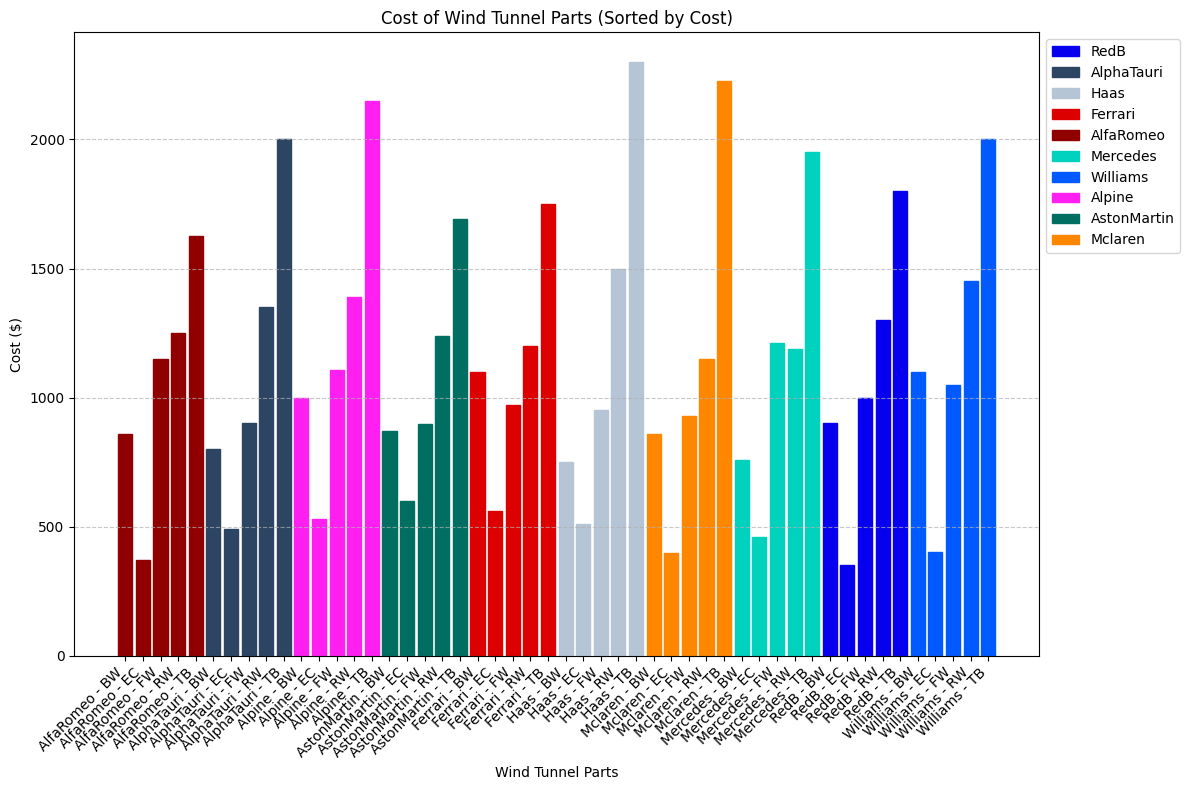

In [66]:
# Extract the costs in the desired order
sorted_costs = [Cost[key] for key in sorted(Cost.keys())]

# Convert tuple keys to strings for plotting
keys_as_strings = [f"{key[0]} - {key[1]}" for key in sorted(Cost.keys())]

# Create a sorted bar plot with colors
plt.figure(figsize=(12, 8))
bars = plt.bar(keys_as_strings, sorted_costs)
legend_patches = []

for key in Cost.keys():
    team = key[0]
    bars[keys_as_strings.index(f"{key[0]} - {key[1]}")].set_color(team_colors[team])

    # Create a legend patch for each unique team
    if team not in [patch.get_label() for patch in legend_patches]:
        legend_patches.append(Patch(color=team_colors[team], label=team))

plt.xlabel("Wind Tunnel Parts")
plt.ylabel("Cost ($)")
plt.title("Cost of Wind Tunnel Parts (Sorted by Cost)")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Display the custom legend with the correct color codes
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In this plot we can see for each Team the cost that each of the 5 possible Components to improve the Car has.
We can see that more or less each component follows a similar distribution and that for example, the TB (Turning Bane) component is the one that has the highest cost.  
Notice that this colours are gonna be associated to this exact teams during all the study, as they are the official colors. 

Now we are going to get the same plot but instead of showing the Cost, we are going to show the Time Improvement that that part produces

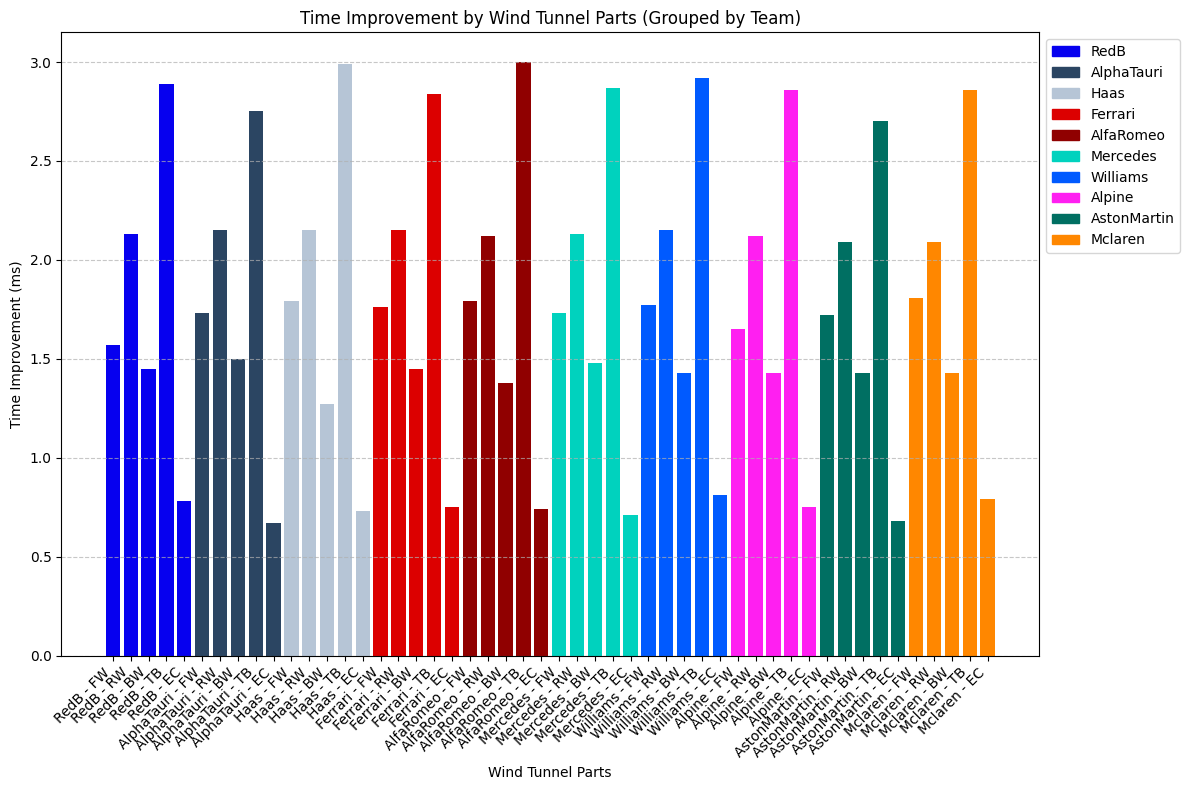

In [67]:
# Extract the improvements in the desired order
sorted_improvements = [ImprovementOfPartByCar[key] for key in sorted(ImprovementOfPartByCar.keys())]

# Convert tuple keys to strings for plotting
keys_as_strings = [f"{key[0]} - {key[2]}" for key in sorted(ImprovementOfPartByCar.keys())]

# Create a sorted bar plot with distinct colors for each team
plt.figure(figsize=(12, 8))
bars = []
legend_patches = []

for key in ImprovementOfPartByCar.keys():
    team = key[0]
    part = key[2]
    team_color = team_colors[team]
    bars.append(plt.bar(keys_as_strings[keys_as_strings.index(f"{key[0]} - {key[2]}")],
                        ImprovementOfPartByCar[key],
                        color=team_color))

    # Create a legend patch for each unique team
    if team not in [patch.get_label() for patch in legend_patches]:
        legend_patches.append(Patch(color=team_color, label=team))

plt.xlabel("Wind Tunnel Parts")
plt.ylabel("Time Improvement (ms)")
plt.title("Time Improvement by Wind Tunnel Parts (Grouped by Team)")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Display the custom legend with the correct color codes
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


We can see that more or less each component follows a similar distribution and that for example, the TB (Turning Bane) component is the one that has the highest time improvement. As it does also the cost. So we can see that Cost and Time are directly related

Now we are going compute the mean and show the average Cost and Time Improvement of each Wind Tunnel Part ($):

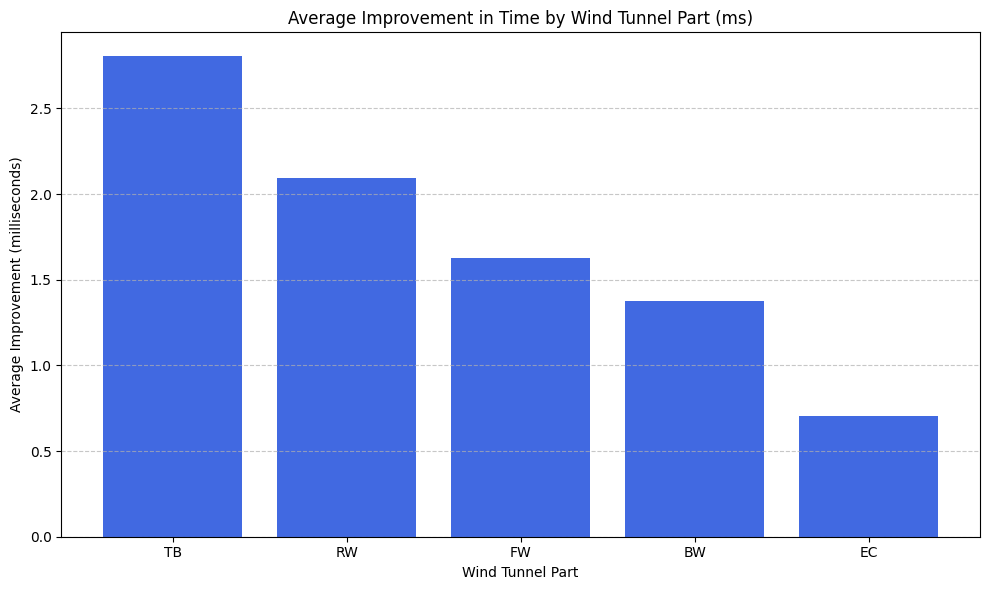

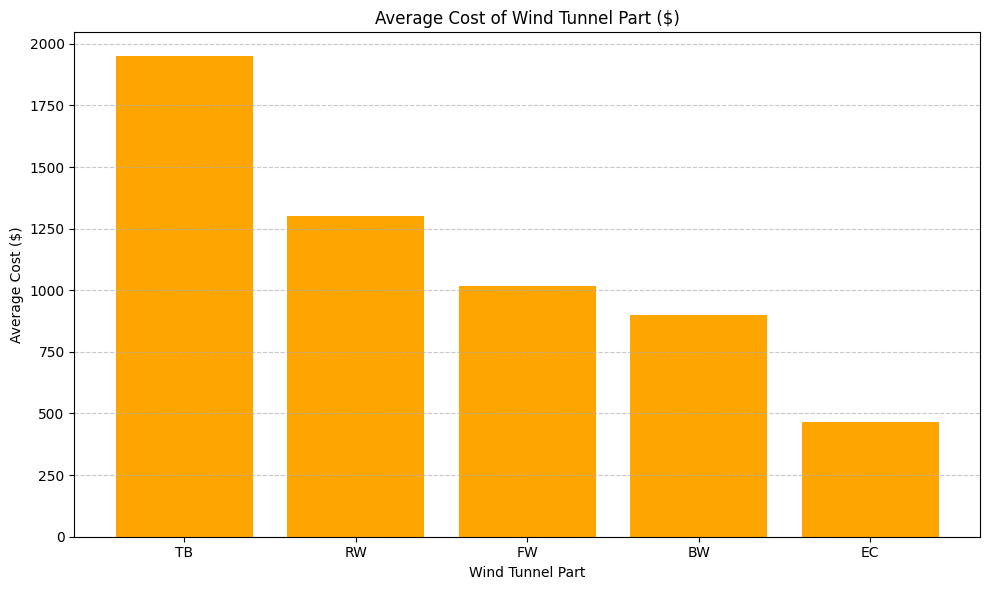

In [68]:
average_improvement = []

for piece in WindTunnelParts:
    piece_improvements = [ImprovementOfPartByCar[(team, car, piece)] for (team, car, part) in ImprovementOfPartByCar if part == piece]
    avg_improvement = np.mean(piece_improvements)
    average_improvement.append(avg_improvement)

# Sort the pieces and their average improvements together
sorted_improvement_data = sorted(zip(WindTunnelParts, average_improvement), key=lambda x: x[1], reverse=True)
piece_names, average_improvement = zip(*sorted_improvement_data)

# Create a sorted bar plot for average improvement
plt.figure(figsize=(10, 6))
plt.bar(piece_names, average_improvement, color='royalblue')
plt.xlabel('Wind Tunnel Part')
plt.ylabel('Average Improvement (milliseconds)')
plt.title('Average Improvement in Time by Wind Tunnel Part (ms)')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid

# Display the plot for average improvement
plt.tight_layout()
plt.show()

average_cost = []

for piece in WindTunnelParts:
    piece_costs = [Cost[(team, part)] for (team, car, part) in ImprovementOfPartByCar if part == piece]
    avg_cost = np.mean(piece_costs)
    average_cost.append(avg_cost)

# Sort the pieces and their average costs together
sorted_cost_data = sorted(zip(WindTunnelParts, average_cost), key=lambda x: x[1], reverse=True)
_, average_cost = zip(*sorted_cost_data)

# Create a sorted bar plot for average cost
plt.figure(figsize=(10, 6))
plt.bar(piece_names, average_cost, color='orange')
plt.xlabel('Wind Tunnel Part')
plt.ylabel('Average Cost ($)')
plt.title('Average Cost of Wind Tunnel Part ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid

# Display the plot for average cost
plt.tight_layout()
plt.show()


As in the previous plots, the most expensive is the TurningBane (TB), and the least is the EngineCover (EC)

Now that we have the average cost of each component and the average time improvement, let´s see which is the one we will probably select the most: 

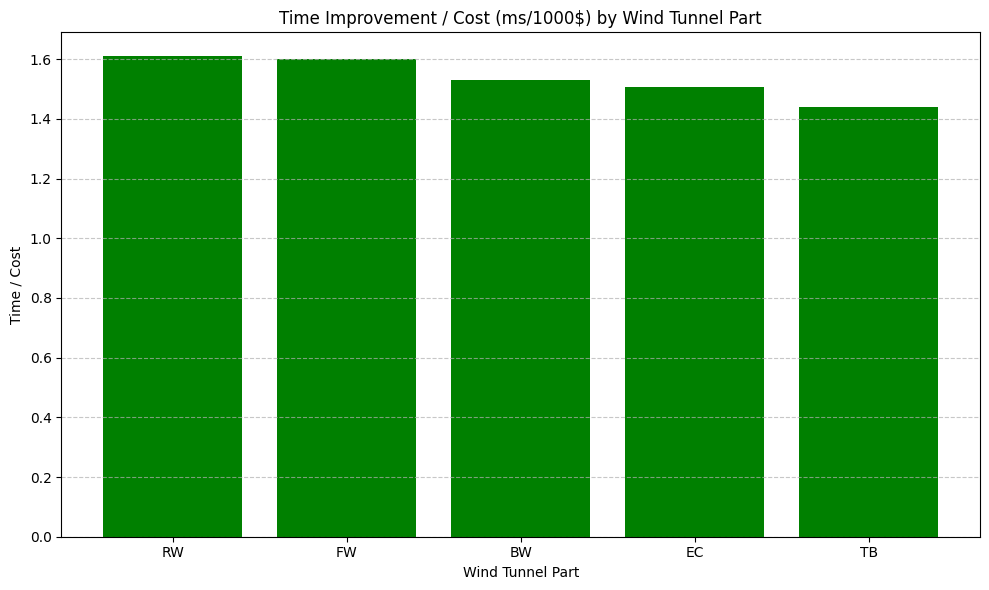

In [69]:
# Calculate the ratio of improvement to cost
ratio_improvement_cost = [improvement*1000 / cost if cost != 0 else 0 for improvement, cost in zip(average_improvement, average_cost)]

# Sort the pieces based on the ratio
sorted_ratio_data = sorted(zip(piece_names, ratio_improvement_cost), key=lambda x: x[1], reverse=True)
sorted_piece_names, sorted_ratio_improvement_cost = zip(*sorted_ratio_data)

# Create a bar plot for the sorted ratio of improvement to cost
plt.figure(figsize=(10, 6))
plt.bar(sorted_piece_names, sorted_ratio_improvement_cost, color='green')
plt.xlabel('Wind Tunnel Part')
plt.ylabel('Time / Cost')
plt.title('Time Improvement / Cost (ms/1000$) by Wind Tunnel Part')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid

# Display the bar plot
plt.tight_layout()
plt.show()


We can see here that in average, the best component is RW, the Rear Wing, so it is likely that this is the most chosen component, if budget or other things do not interfere in our model. 

## Model Definition



\begin{align*}
& \text{Variables:} \\
& x_{ijk} \geq 0, \quad \forall k \in \text{Teams}, \forall i \in \text{Cars}, \forall j \in \text{WindTunnelParts} \\
& \text{where } x_{ijk} \text{ represents the number of times that on team } k \text{ with car } i \text{ piece } j \text{ is tuned on the tunnel.} \\
& \text{with } x \in \mathbb{R}^{\geq 0}
\end{align*}



\begin{align*}
\text{maximize } & \sum_{k \in \text{Teams}} \sum_{i \in \text{Cars}} \sum_{j \in \text{WindTunnelParts}} \text{partImprove}[k,i,j] \cdot x[k,i,j] \\
\text{subject to } \\
& x[k,i,j] \leq \text{partUse}[j] & \forall k \in \text{Teams}, \forall i \in \text{Cars}, \forall j \in \text{WindTunnelParts} \\

& x[k,i,j] \geq 0 & \forall k \in \text{Teams}, \forall i \in \text{Cars}, \forall j \in \text{WindTunnelParts} \\

\text{BudgetTeam:} & \quad \sum_{i \in \text{Cars}} \sum_{j \in \text{WindTunnelParts}} \text{Cost}[k,j] \cdot x[k,i,j] \leq \text{budgetTeam}[k] & \forall k \in \text{Teams} \\
\text{BudgetTunnel:} & \quad \sum_{i \in \text{Cars}} \text{Cost}[k,j] \cdot x[k,i,j] \leq \text{budgetPart}[k,j] & \forall k \in \text{Teams}, \forall j \in \text{WindTunnelParts} \\
\text{BudgetCar:} & \quad \sum_{j \in \text{WindTunnelParts}} \text{Cost}[k,j] \cdot x[k,i,j] \leq \text{budgetCar}[k,i] & \forall k \in \text{Teams}, \forall i \in \text{Cars}
\end{align*}


- The number of components used cannot be larger than the number of available components.
- We cannot invest negative money. (Time cannot be negative too) 
- Each Team is allowed a maximum amount of the budget to invest.
- Each Wind Tunnel Component has a maximum budget
- Each Car of the teams has a specific percentage of the total budget of the team

In [70]:
model = ConcreteModel()

model.dual=Suffix(direction=Suffix.IMPORT) # Compute and store the dual values (that we also know as shadow prices) for the constraints when solving the optimization problem.

# Variables: 
model.i = Set(initialize=Cars, doc='Cars' )
model.j = Set(initialize = WindTunnelParts, doc="WindTunnelPart")
model.k = Set(initialize = Teams, doc="Teams")

# Parameters
model.Cost = Param(model.k, model.j, initialize=Cost, doc='Wind Tunnel Costs for Each Team')
model.partImprove = Param(model.k, model.i, model.j, initialize=ImprovementOfPartByCar, within=NonNegativeReals,doc="Time Improvement of a car if that part is used on wind tunnel" )
model.partUse = Param(model.j, initialize=partUse, doc='Maximum number of uses of WindTunnel runs for a specific part of the car')
model.percentageCar = Param(model.k, model.i, initialize=percentageCar, doc='Percentage of money that each team assigns to each car')

model.budgetTeam = Param(model.k, initialize=budgetTeam, doc='Budget allocated to each Team')

def budgetCar_rule(model, k, i):
    return model.budgetTeam[k] * model.percentageCar[k,i]

model.budgetCar = Param(model.k, model.i, rule=budgetCar_rule, doc='Budget allocated to each car')
#model.budgetPart = Param(model.k, model.j, initialize = {part: model.Cost[team, part] * model.partUse[part] for team, part in Cost.keys()}, doc='Maximum budget for a specific part of the car of each team in the wind tunnel')

def budgetPart_rule(model, team, part):
    return model.Cost[team, part] * model.partUse[part]

model.budgetPart = Param(model.k, model.j, rule=budgetPart_rule, doc='Maximum budget for a specific part of the car of each team in the wind tunnel')

# define variables here
model.x = Var(model.k, model.i, model.j, doc = "Times that on team k with car i piece j is tunned on the tunnel", within = NonNegativeReals)


In [71]:
# define objective here
def objective_rule(model):
    return sum(model.partImprove[k,i,j]*model.x[k,i,j] for k in model.k for i in model.i for j in model.j)

model.obj = Objective(rule = objective_rule, sense = maximize, doc = "Total Time Improvement in seconds")


In [72]:
# Constraints
def BudgetTeam(model, k):
    return sum(model.Cost[k,j] * model.x[k,i,j]  for i in model.i for j in model.j) <= model.budgetTeam[k]

def BudgetTunnel(model, k,j):
    return sum(model.Cost[k,j] * model.x[k,i,j]  for i in model.i)                  <= model.budgetPart[k,j]

def BudgetCar(model, k, i):
    return sum(model.Cost[k,j] * model.x[k,i,j]  for j in model.j)                  <= model.budgetCar[k,i]


model.BudgetTeam   = Constraint(model.k,          rule = BudgetTeam,   doc = "Maximum Budget allowed for each Team")
model.BudgetTunnel = Constraint(model.k, model.j, rule = BudgetTunnel, doc = "Maximum Budget allowed for each Wind Tunnel Part")
model.BudgetCar    = Constraint(model.k, model.i, rule = BudgetCar,    doc = "Maximum Budget allowed for each Car of each Team")

In [73]:
# Define a solver 
Solver = SolverFactory('glpk')

# Obtain the solution
Results = Solver.solve(model)

# Display the solution
model.display()


Model unknown

  Variables:
    x : Times that on team k with car i piece j is tunned on the tunnel
        Size=100, Index=x_index
        Key                         : Lower : Value            : Upper : Fixed : Stale : Domain
          ('AlfaRomeo', 'C1', 'BW') :     0 :              0.0 :  None : False : False : NonNegativeReals
          ('AlfaRomeo', 'C1', 'EC') :     0 :              0.0 :  None : False : False : NonNegativeReals
          ('AlfaRomeo', 'C1', 'FW') :     0 :              0.0 :  None : False : False : NonNegativeReals
          ('AlfaRomeo', 'C1', 'RW') :     0 :              0.0 :  None : False : False : NonNegativeReals
          ('AlfaRomeo', 'C1', 'TB') :     0 : 23.7784615384615 :  None : False : False : NonNegativeReals
          ('AlfaRomeo', 'C2', 'BW') :     0 :              0.0 :  None : False : False : NonNegativeReals
          ('AlfaRomeo', 'C2', 'EC') :     0 :             90.0 :  None : False : False : NonNegativeReals
          ('AlfaRomeo', 'C2', 

# Model Analysis: 

In this section we are going to compute the money invested in all the parts, in all the cars and in all the teams. Then we will do it with the time improvement we obtain.

In [74]:
# Display total time improvement

print(f"Time improvement in all the cars and pieces together: {model.obj()} milliseconds")

Time improvement in all the cars and pieces together: 2124.230593400751 milliseconds


# Budget Allocation: 

In [75]:
part_quantities = {}  # Create an empty dictionary to store variable values
total_sum_for_car = {}
total_sum_for_team = {}

for k in model.k:
    for i in model.i:
        for j in model.j:
            part_quantities[(k, i, j)] = model.x[k,i, j].value * model.Cost[k,j]
            total_sum_for_car[k,i] = sum(model.x[k, i, j].value* model.Cost[k,j] for j in model.j)
            total_sum_for_team[k] = sum(model.x[k, i, j].value* model.Cost[k,j] for i in model.i for j in model.j)

print("***** Budget Allocated To each Piece of each car of each Team *****")
for (k,i, j), value in part_quantities.items():
    if(value>0):
        print(f"Budget allocated to [{k}, {i}, {j}] = {value} $")

***** Budget Allocated To each Piece of each car of each Team *****
Budget allocated to [RedB, C1, BW] = 8999.99999999999 $
Budget allocated to [RedB, C1, EC] = 31500.0 $
Budget allocated to [RedB, C2, RW] = 49500.00000000003 $
Budget allocated to [AlphaTauri, C1, BW] = 52440.0 $
Budget allocated to [AlphaTauri, C2, FW] = 53100.0 $
Budget allocated to [AlphaTauri, C2, RW] = 20100.000000000015 $
Budget allocated to [AlphaTauri, C2, BW] = 12360.0 $
Budget allocated to [Haas, C1, RW] = 12750.0 $
Budget allocated to [Haas, C1, BW] = 60750.0 $
Budget allocated to [Haas, C2, FW] = 56050.0 $
Budget allocated to [Haas, C2, RW] = 20449.999999999953 $
Budget allocated to [Ferrari, C1, RW] = 54060.0 $
Budget allocated to [Ferrari, C2, FW] = 47939.99999999997 $
Budget allocated to [AlfaRomeo, C1, TB] = 38639.999999999935 $
Budget allocated to [AlfaRomeo, C2, RW] = 66060.0 $
Budget allocated to [AlfaRomeo, C2, EC] = 33300.0 $
Budget allocated to [Mercedes, C1, BW] = 26520.00000000003 $
Budget alloc

If any component is not shown here, it is because the money allocated it´s zero. 

Now, let´s plot it

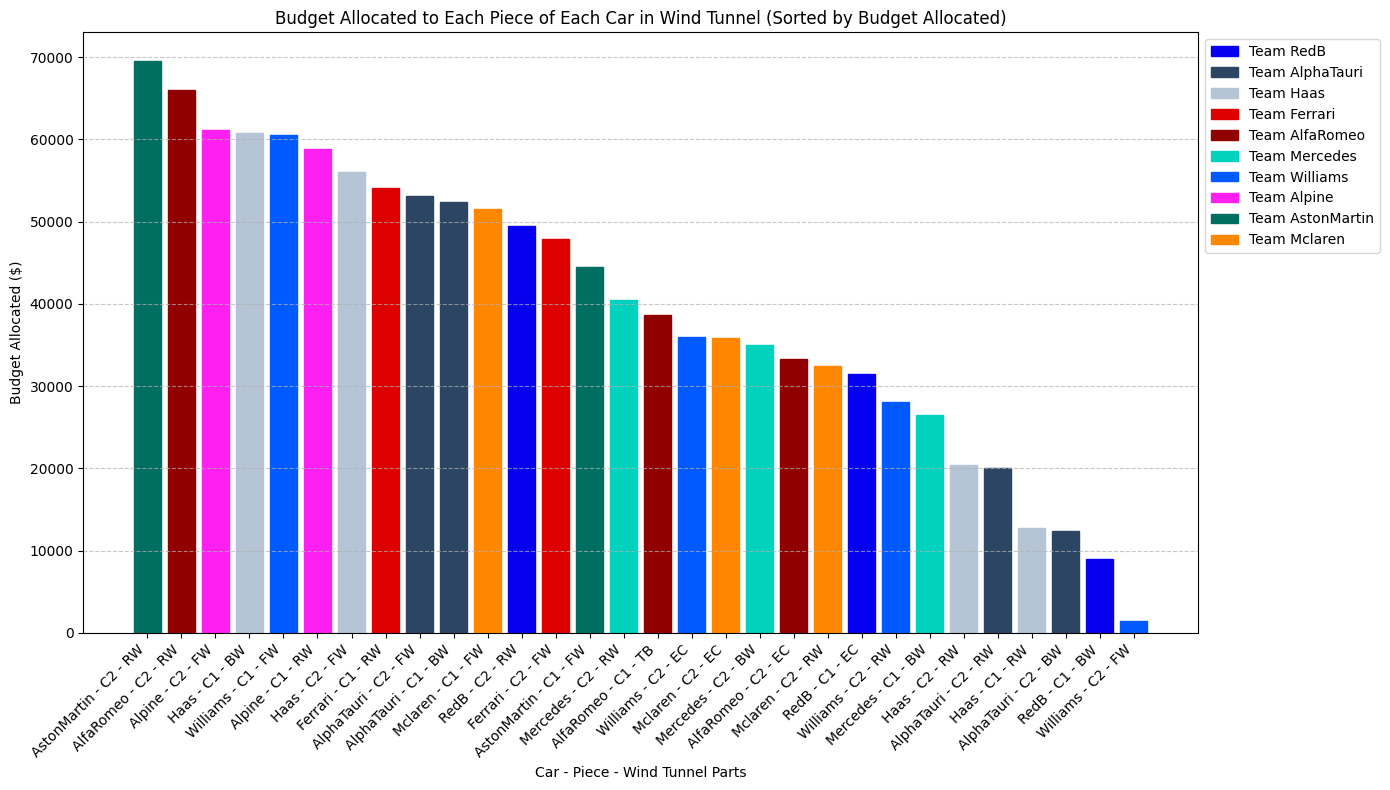

In [76]:
# Filter out items with zero budget allocation
non_zero_part_quantities = {k: v for k, v in part_quantities.items() if v != 0}

# Sort the filtered dictionary by value in descending order
sorted_part_quantities = {k: v for k, v in sorted(non_zero_part_quantities.items(), key=lambda item: item[1], reverse=True)}

# Extract the values (budget allocated)
values = list(sorted_part_quantities.values())

# Convert the keys to strings for plotting
keys_as_strings = [f"{k[0]} - {k[1]} - {k[2]}" for k in sorted_part_quantities.keys()]

# Create a bar plot with colors
plt.figure(figsize=(14, 8))
bars = plt.bar(keys_as_strings, values)
for k in sorted_part_quantities.keys():
    team = k[0]
    bars[keys_as_strings.index(f"{k[0]} - {k[1]} - {k[2]}")].set_color(team_colors[team])

# Create legend with team colors outside the plot
legend_labels = {team: f'Team {team}' for team in team_colors}
handles = [plt.Rectangle((0,0),1,1, color=team_colors[label]) for label in legend_labels]
plt.legend(handles, legend_labels.values(), loc='upper left', bbox_to_anchor=(1, 1))

plt.xlabel("Car - Piece - Wind Tunnel Parts")
plt.ylabel("Budget Allocated ($)")
plt.title("Budget Allocated to Each Piece of Each Car in Wind Tunnel (Sorted by Budget Allocated)")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Display the plot
plt.tight_layout()
plt.show()


We can see that most of the teams only invest in 1 or 2 pieces for each car, as we have plenty of them, and the optimization algorithm finds the one that improves the highest, the optimal one.
The most expensive part is the Rear Wing of the Second Car in Aston Martin, we will have to check if that piece is also the one that gives back a higher reward in time. 

In [77]:
print("***** Budget Allocated To each Car of each Team *****")

for i, total_sum in total_sum_for_car.items():
    print(f"Money invested in {i} on the Wind Tunnel is: {total_sum} $")


***** Budget Allocated To each Car of each Team *****
Money invested in ('RedB', 'C1') on the Wind Tunnel is: 40499.99999999999 $
Money invested in ('RedB', 'C2') on the Wind Tunnel is: 49500.00000000003 $
Money invested in ('AlphaTauri', 'C1') on the Wind Tunnel is: 52440.0 $
Money invested in ('AlphaTauri', 'C2') on the Wind Tunnel is: 85560.00000000001 $
Money invested in ('Haas', 'C1') on the Wind Tunnel is: 73500.0 $
Money invested in ('Haas', 'C2') on the Wind Tunnel is: 76499.99999999996 $
Money invested in ('Ferrari', 'C1') on the Wind Tunnel is: 54060.0 $
Money invested in ('Ferrari', 'C2') on the Wind Tunnel is: 47939.99999999997 $
Money invested in ('AlfaRomeo', 'C1') on the Wind Tunnel is: 38639.999999999935 $
Money invested in ('AlfaRomeo', 'C2') on the Wind Tunnel is: 99360.0 $
Money invested in ('Mercedes', 'C1') on the Wind Tunnel is: 26520.00000000003 $
Money invested in ('Mercedes', 'C2') on the Wind Tunnel is: 75479.99999999994 $
Money invested in ('Williams', 'C1') 

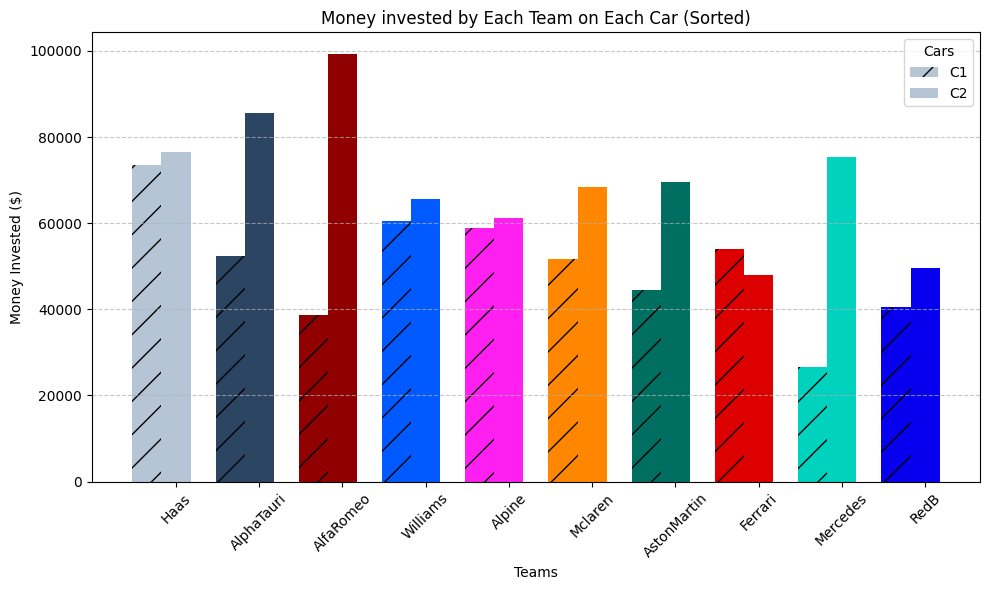

In [78]:
# Create a list to store time improvements for each team and car
money_invested = []

# Populate the money_invested list with the data
for team in Teams:
    for car in Cars:
        money = total_sum_for_car.get((team, car), 0)
        money_invested.append(money)

# Sort the teams based on time improvement (ascending order)
Teams.sort(key=lambda team: -(total_sum_for_car[(team, 'C1')] + total_sum_for_car[(team, 'C2')]))

# Create a bar plot with custom colors and sorted teams
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
x = range(len(Teams))

for i, car in enumerate(Cars):
    car_money_invested = [total_sum_for_car[(team, car)] for team in Teams]
    team_color = [team_colors[team] for team in Teams]
    ax.bar(
        [pos + i * width for pos in x],
        car_money_invested,
        width,
        label=f"{car}",
        color=team_color,
        hatch='/' if car == 'C1' else '',  # Use hatching for Car 1

    )

ax.set_xlabel("Teams")
ax.set_ylabel("Money Invested ($)")
ax.set_title("Money invested by Each Team on Each Car (Sorted)")
ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(Teams)
ax.legend(title="Cars")

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid

plt.show()


This plot is conditioned by the constraint we applied while defining how much money each team decides to invest in each of the cars. In Alfa Romeo and Mercedes the difference is huge.
This could be solution of the teams to try to improve the worst car of the team. 

In [79]:
print("***** Budget Allocated To each Team *****")

total_money_invested_team = 0
for i, total_sum in total_sum_for_team.items():
    print(f"Money invested in {i} on the Wind Tunnel is: {total_sum} $")
    total_money_invested_team += total_sum

print("\nTotal money invested:",round(total_money_invested_team,3), "$ Out of total available budget: ", max_budget, "$")


***** Budget Allocated To each Team *****
Money invested in RedB on the Wind Tunnel is: 90000.00000000003 $
Money invested in AlphaTauri on the Wind Tunnel is: 138000.0 $
Money invested in Haas on the Wind Tunnel is: 149999.99999999994 $
Money invested in Ferrari on the Wind Tunnel is: 101999.99999999997 $
Money invested in AlfaRomeo on the Wind Tunnel is: 137999.99999999994 $
Money invested in Mercedes on the Wind Tunnel is: 101999.99999999997 $
Money invested in Williams on the Wind Tunnel is: 126000.0 $
Money invested in Alpine on the Wind Tunnel is: 120000.00000000003 $
Money invested in AstonMartin on the Wind Tunnel is: 113999.99999999993 $
Money invested in Mclaren on the Wind Tunnel is: 120000.0 $

Total money invested: 1200000.0 $ Out of total available budget:  1200000 $


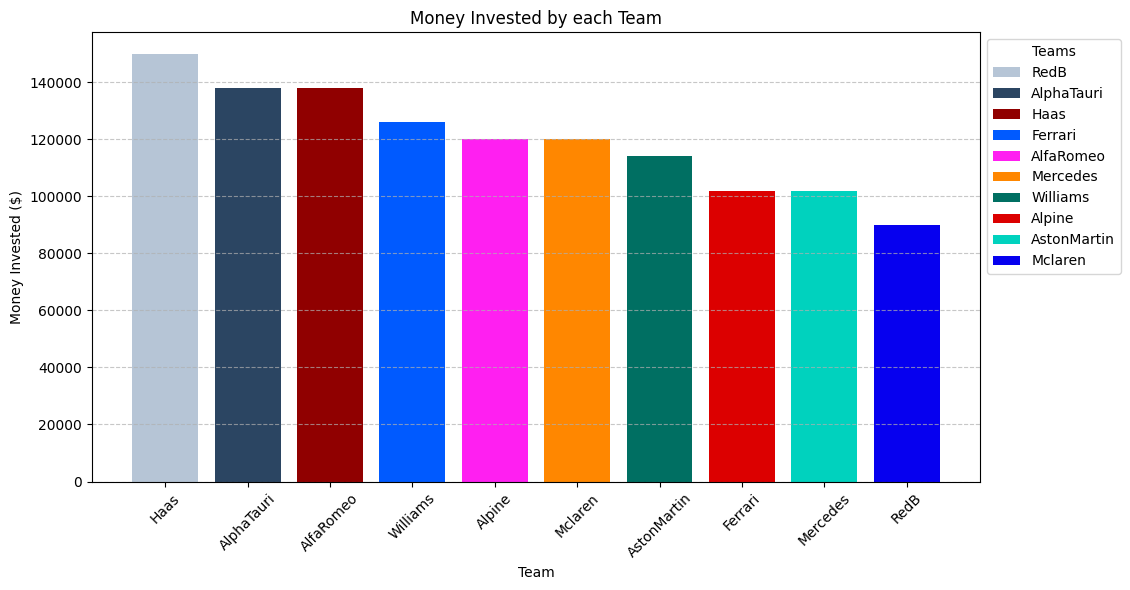

In [80]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sorted_data = dict(sorted(total_sum_for_team.items(), key=lambda item: item[1], reverse=True))
teams = list(sorted_data.keys())
improvements = list(sorted_data.values())

bars = plt.bar(teams, improvements,  color=[team_colors[team] for team in teams])
plt.xlabel('Team')
plt.ylabel('Money Invested ($)')
plt.title('Money Invested by each Team')
plt.xticks(rotation=45)  # Rotate team names for better readability
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid

# Create legend with team labels outside the plot
legend_labels = list(total_sum_for_team.keys())
legend = plt.legend(bars, legend_labels, title="Teams", loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot with the legend outside
plt.show()


In [81]:
print(budgetTeam)

{'RedB': 90000.0, 'AlphaTauri': 138000.0, 'Haas': 150000.0, 'Ferrari': 102000.00000000001, 'AlfaRomeo': 138000.0, 'Mercedes': 102000.00000000001, 'Williams': 126000.0, 'Alpine': 120000.0, 'AstonMartin': 114000.0, 'Mclaren': 120000.0}


We can see that the Teams are ordered as our constraint of money allocated does not allow them to spend more money than the budget allocated. As the full budget is spent, we can see the values directly on the plot

# Time Improvements
Now we are going to plot as with the money, the Time Improvement for all the pieces, cars and teams

In [82]:
final_results = {}
total_time_for_team = {}

for (k, i, j), value in part_quantities.items():
    if (k, i, j) in ImprovementOfPartByCar and (k, j) in model.Cost:
        improvement_factor = ImprovementOfPartByCar[(k, i, j)]
        cost_value = model.Cost[(k, j)]
        final_results[(k, i, j)] = (value * improvement_factor / cost_value)  # The chosen number of pieces times the time that the car increases divided by the cost of choosing this piece.
        total_sum_for_car[k, i] = sum(model.x[k, i, j].value * ImprovementOfPartByCar[k, i, j] for j in model.j)
        total_time_for_team[k] = sum(model.x[k, i, j].value * ImprovementOfPartByCar[k, i, j] for i in model.i for j in model.j)

print("***** Time Improved by each Piece of each car of each Team *****")
for (k, i, j), final_result in final_results.items():
    if(final_result>0):
        print(f"Time Improvement in {k}, {i} by tunning {j} on the Wind Tunnel is {round(final_result, 5)} milliseconds")


***** Time Improved by each Piece of each car of each Team *****
Time Improvement in RedB, C1 by tunning BW on the Wind Tunnel is 14.5 milliseconds
Time Improvement in RedB, C1 by tunning EC on the Wind Tunnel is 70.2 milliseconds
Time Improvement in RedB, C2 by tunning RW on the Wind Tunnel is 81.10385 milliseconds
Time Improvement in AlphaTauri, C1 by tunning BW on the Wind Tunnel is 98.325 milliseconds
Time Improvement in AlphaTauri, C2 by tunning FW on the Wind Tunnel is 102.07 milliseconds
Time Improvement in AlphaTauri, C2 by tunning RW on the Wind Tunnel is 30.22444 milliseconds
Time Improvement in AlphaTauri, C2 by tunning BW on the Wind Tunnel is 19.467 milliseconds
Time Improvement in Haas, C1 by tunning RW on the Wind Tunnel is 18.275 milliseconds
Time Improvement in Haas, C1 by tunning BW on the Wind Tunnel is 102.87 milliseconds
Time Improvement in Haas, C2 by tunning FW on the Wind Tunnel is 105.61 milliseconds
Time Improvement in Haas, C2 by tunning RW on the Wind Tunnel

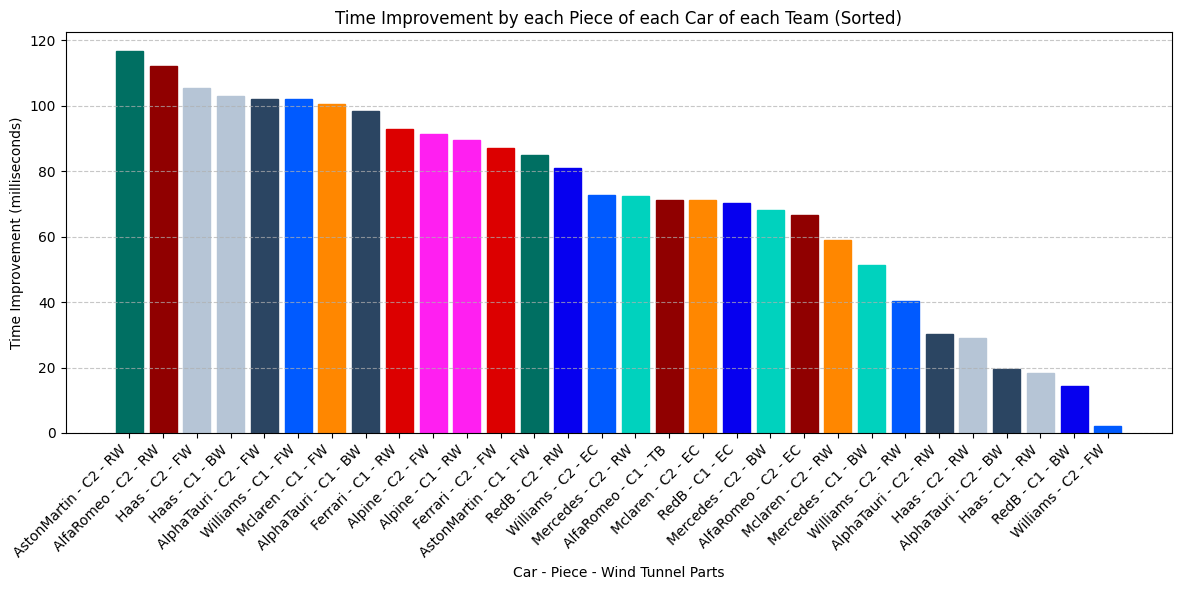

In [83]:
# Filter out items with zero budget allocation
non_zero_final_results = {k: v for k, v in final_results.items() if v != 0}

# Sort the filtered dictionary by value in descending order
sorted_final_results = {k: v for k, v in sorted(non_zero_final_results.items(), key=lambda item: item[1], reverse=True)}

# Extract the values (Time Improvement)
values = list(sorted_final_results.values())

# Convert the keys to strings for plotting
keys_as_strings = [f"{k[0]} - {k[1]} - {k[2]}" for k in sorted_final_results.keys()]

# Create a bar plot with colors
plt.figure(figsize=(12, 6))
bars = plt.bar(keys_as_strings, values)
for k in sorted_final_results.keys():
    team = k[0]
    bars[keys_as_strings.index(f"{k[0]} - {k[1]} - {k[2]}")].set_color(team_colors[team])

plt.xlabel("Car - Piece - Wind Tunnel Parts")
plt.ylabel("Time Improvement (milliseconds)")
plt.title("Time Improvement by each Piece of each Car of each Team (Sorted)")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")


# Display the plot
plt.tight_layout()
plt.show()


As we expected, the piece that was the most expensive one, the Rear Wing of Aston Martin for the second car, is the one that also gives the best time improvement, of almost 120 milliseconds. 
This is the optimal model, so we would not have selected that piece if the time improvement wasnt considerable.  

Now we are going to see the time for each Car

In [84]:
print("***** Time Improved on each Car of each Team *****")

for i, total_sum in total_sum_for_car.items():
    print(f"Time Improvement in {i} on the Wind Tunnel is: {total_sum} milliseconds")


***** Time Improved on each Car of each Team *****
Time Improvement in ('RedB', 'C1') on the Wind Tunnel is: 84.69999999999999 milliseconds
Time Improvement in ('RedB', 'C2') on the Wind Tunnel is: 81.1038461538462 milliseconds
Time Improvement in ('AlphaTauri', 'C1') on the Wind Tunnel is: 98.32499999999999 milliseconds
Time Improvement in ('AlphaTauri', 'C2') on the Wind Tunnel is: 151.76144444444446 milliseconds
Time Improvement in ('Haas', 'C1') on the Wind Tunnel is: 121.14500000000001 milliseconds
Time Improvement in ('Haas', 'C2') on the Wind Tunnel is: 134.64899999999994 milliseconds
Time Improvement in ('Ferrari', 'C1') on the Wind Tunnel is: 92.803 milliseconds
Time Improvement in ('Ferrari', 'C2') on the Wind Tunnel is: 86.98391752577314 milliseconds
Time Improvement in ('AlfaRomeo', 'C1') on the Wind Tunnel is: 71.3353846153845 milliseconds
Time Improvement in ('AlfaRomeo', 'C2') on the Wind Tunnel is: 178.63776000000001 milliseconds
Time Improvement in ('Mercedes', 'C1') o

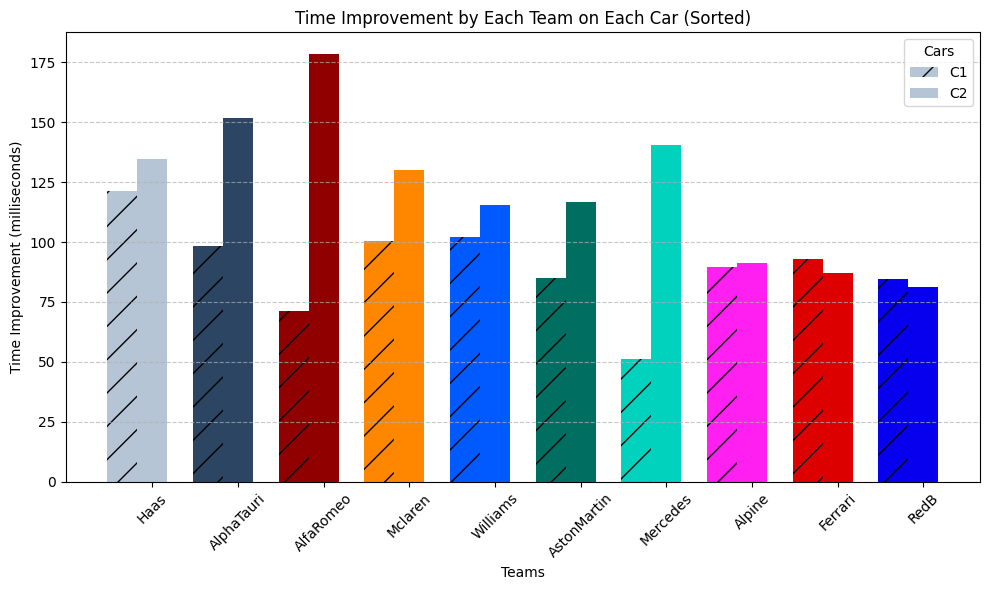

In [85]:
import matplotlib.pyplot as plt

# Create a list to store time improvements for each team and car
time_improvements = []

# Populate the time_improvements list with the data
for team in Teams:
    for car in Cars:
        time_improvement = total_sum_for_car.get((team, car), 0)
        time_improvements.append(time_improvement)

# Sort the teams based on time improvement (ascending order)
Teams.sort(key=lambda team: -(total_sum_for_car[(team, 'C1')] + total_sum_for_car[(team, 'C2')]))

# Create a bar plot with custom colors and sorted teams
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
x = range(len(Teams))

for i, car in enumerate(Cars):
    car_time_improvements = [total_sum_for_car[(team, car)] for team in Teams]
    team_color = [team_colors[team] for team in Teams]
    ax.bar(
        [pos + i * width for pos in x],
        car_time_improvements,
        width,
        label=f"{car}",
        color=team_color,
        hatch='/' if car == 'C1' else '',  # Use hatching for Car 1

    )

ax.set_xlabel("Teams")
ax.set_ylabel("Time Improvement (milliseconds)")
ax.set_title("Time Improvement by Each Team on Each Car (Sorted)")
ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(Teams)
ax.legend(title="Cars")

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid

plt.show()


Quite similar plot to the budget allocated, biggest differences are between Alfa Romeo and Mercedes team. 

In [86]:
print("***** Time Improved by each Team *****")

total_time_improved = 0
for i, total_sum in total_time_for_team.items():
    print(f"Time Improved in {i} on the Wind Tunnel is: {total_sum} milliseconds")
    total_time_improved += total_sum

print(f"\nTotal Time Improvement is: {model.obj()} that matches {total_time_improved} miliseconds")

***** Time Improved by each Team *****
Time Improved in RedB on the Wind Tunnel is: 165.8038461538462 milliseconds
Time Improved in AlphaTauri on the Wind Tunnel is: 250.08644444444445 milliseconds
Time Improved in Haas on the Wind Tunnel is: 255.79399999999993 milliseconds
Time Improved in Ferrari on the Wind Tunnel is: 179.78691752577313 milliseconds
Time Improved in AlfaRomeo on the Wind Tunnel is: 249.97314461538448 milliseconds
Time Improved in Mercedes on the Wind Tunnel is: 191.91525431225116 milliseconds
Time Improved in Williams on the Wind Tunnel is: 217.52268965517243 milliseconds
Time Improved in Alpine on the Wind Tunnel is: 181.06519092418375 milliseconds
Time Improved in AstonMartin on the Wind Tunnel is: 201.71025583982188 milliseconds
Time Improved in Mclaren on the Wind Tunnel is: 230.57284992987377 milliseconds

Total Time Improvement is: 2124.230593400751 that matches 2124.230593400751 miliseconds


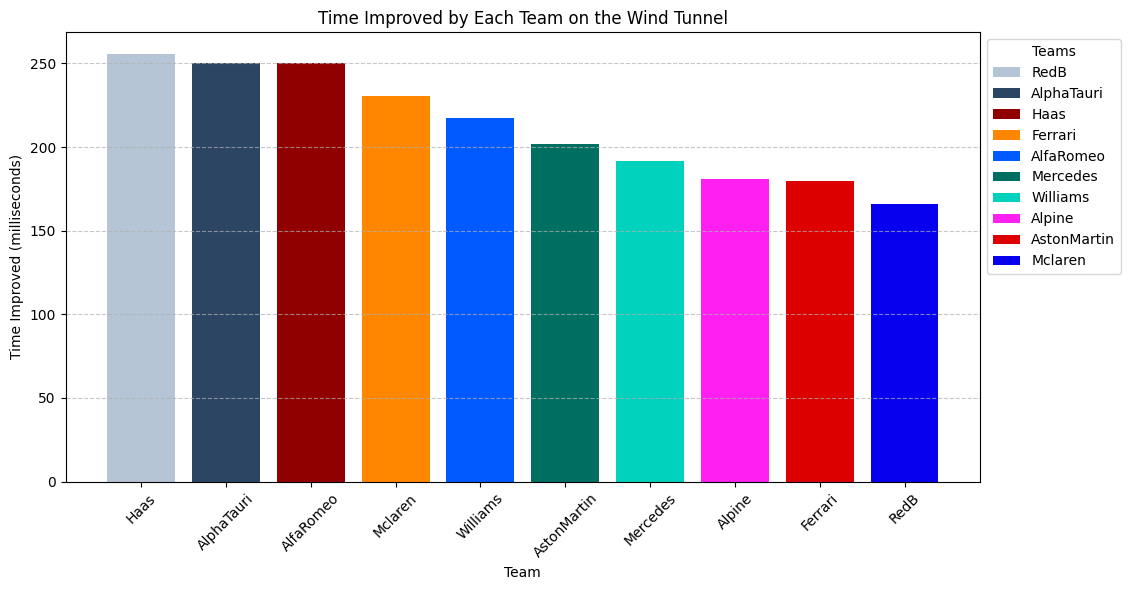

In [87]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sorted_data = dict(sorted(total_time_for_team.items(), key=lambda item: item[1], reverse=True))
teams = list(sorted_data.keys())
improvements = list(sorted_data.values())

bars = plt.bar(teams, improvements, color=[team_colors[team] for team in teams])
plt.xlabel('Team')
plt.ylabel('Time Improved (milliseconds)')
plt.title('Time Improved by Each Team on the Wind Tunnel')
plt.xticks(rotation=45)  # Rotate team names for better readability
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid

# Create legend with team labels outside the plot
legend_labels = list(total_time_for_team.keys())
legend = plt.legend(bars, legend_labels, title="Teams", loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot with the legend outside
plt.show()


We can see that as intended, the teams that were worst in the last season, that were given less money, are the ones that have improved their time the most. 
Here we are shown the inverse order of the allocated money to each of them. 

# Part 1 First Conclusion: 

The Time improvement corresponds to the money allocated to each team, but in order to see something, we are going to obtain the number of milliseconds we obtain per 1000 dollars invested. 
This is going to tell us how efficient is each team investing its money:   

{'RedB': 90000.00000000003, 'AlphaTauri': 138000.0, 'Haas': 149999.99999999994, 'Ferrari': 101999.99999999997, 'AlfaRomeo': 137999.99999999994, 'Mercedes': 101999.99999999997, 'Williams': 126000.0, 'Alpine': 120000.00000000003, 'AstonMartin': 113999.99999999993, 'Mclaren': 120000.0}
{'RedB': 165.8038461538462, 'AlphaTauri': 250.08644444444445, 'Haas': 255.79399999999993, 'Ferrari': 179.78691752577313, 'AlfaRomeo': 249.97314461538448, 'Mercedes': 191.91525431225116, 'Williams': 217.52268965517243, 'Alpine': 181.06519092418375, 'AstonMartin': 201.71025583982188, 'Mclaren': 230.57284992987377}
[1.8422649572649572, 1.8122206119162643, 1.7052933333333335, 1.7626168384879726, 1.8113995986622073, 1.881522101100502, 1.7263705528188287, 1.5088765910348643, 1.7693882091212456, 1.9214404160822813]


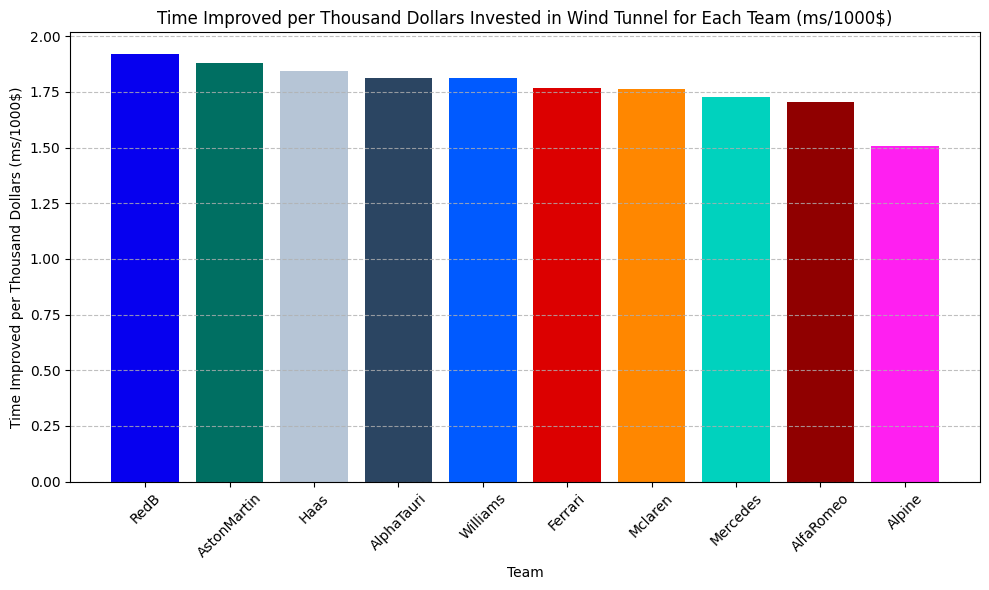

In [88]:
print(total_sum_for_team) # money
print(total_time_for_team) # time

improvement = []
# Calculate improvement for each team
for team in total_sum_for_team:
    improvement.append(total_time_for_team[team] / total_sum_for_team[team] * 1000)

print(improvement)

# Sort the data by time improvements in descending order
sorted_data = sorted(zip(Teams, improvement), key=lambda x: x[1], reverse=True)
teams, improvement_1 = zip(*sorted_data)

# Create a sorted bar plot
plt.figure(figsize=(10, 6))
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.bar(teams, improvement_1,  color=[team_colors[team] for team in teams])
plt.xlabel('Team')
plt.ylabel('Time Improved per Thousand Dollars (ms/1000$)')
plt.title('Time Improved per Thousand Dollars Invested in Wind Tunnel for Each Team (ms/1000$)')
plt.xticks(rotation=45)  # Rotate team names for better readability
plt.tight_layout()

# Display the plot
plt.show()

We can see that the improvement between the teams has a really small variation. The best team is Redbull, that improves almost 2 ms per 1000$, while Alpine improves 1.5 ms per 1000$. 
This is the key point to success in this sport, as the budget limits quite a lot how much each team improves. If Alpine keeps on this line, they will be losing races for a long time until they manage to manage better the Cost associated to their Wind Tunnel parts.  

# Wind Tunnel Components Analysis
Now instead of looking by Teams, let´s check by components how is the development of the parts: 

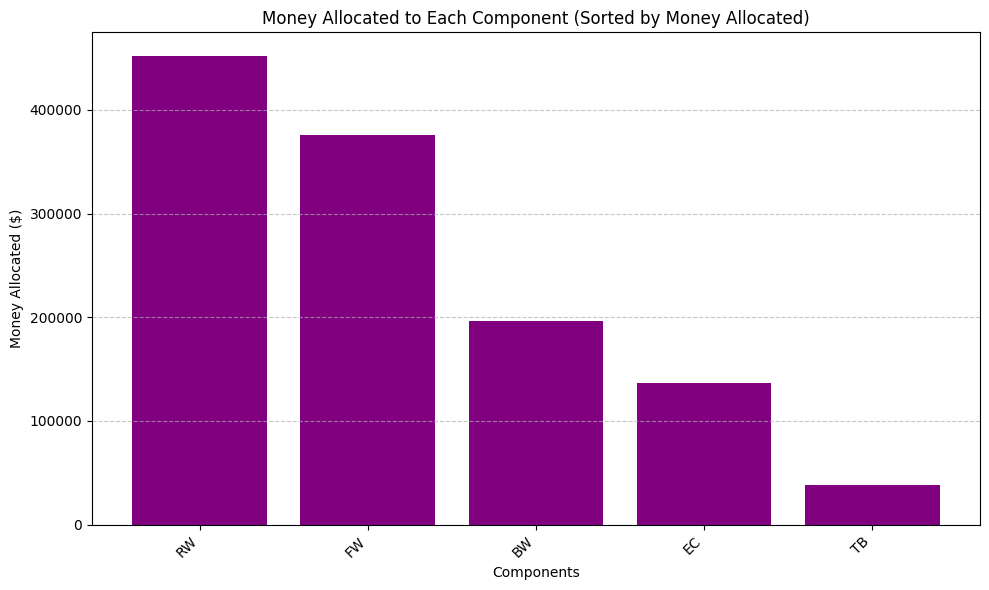

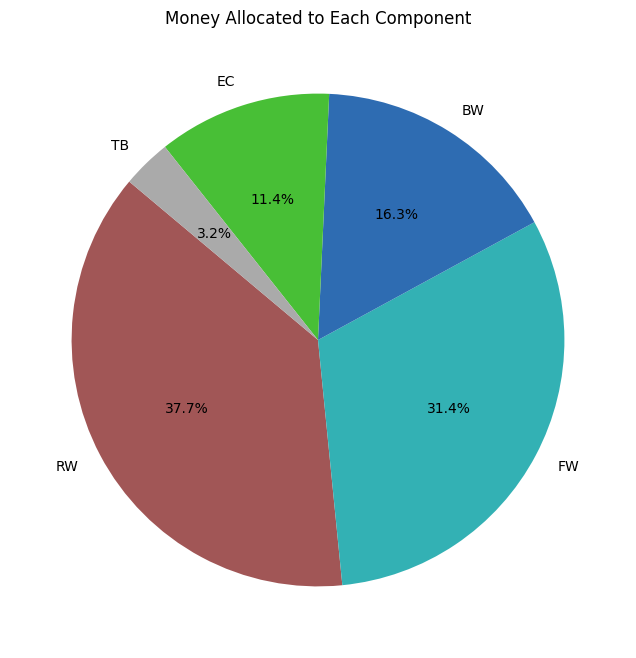

In [89]:
# Get Money Allocated to Each Component
component_allocation = {}

for j in model.j:
    component_allocation[j] = sum(model.x[k, i, j].value * model.Cost[k, j] for k in model.k for i in model.i)

# Sort the components by money allocated (in descending order)
sorted_components = sorted(component_allocation, key=lambda component: -component_allocation[component])

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(sorted_components))

money_allocated = [component_allocation[component] for component in sorted_components]

ax.bar(x, money_allocated, tick_label=sorted_components, color='purple')
ax.set_xlabel("Components")
ax.set_ylabel("Money Allocated ($)")
ax.set_title("Money Allocated to Each Component (Sorted by Money Allocated)")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid

plt.show()


fig, ax = plt.subplots(figsize=(8,8))

N = len(sorted_components)

# Data for the pie chart
money_allocated_top_n = [component_allocation[component] for component in sorted_components[:N]]
components_top_n = sorted_components[:N]

ax.pie(money_allocated_top_n, labels=components_top_n, colors = piechart_colors, autopct='%1.1f%%', startangle=140)

# Add a title
ax.set_title('Money Allocated to Each Component'.format(N))

# Show the pie chart
plt.show()


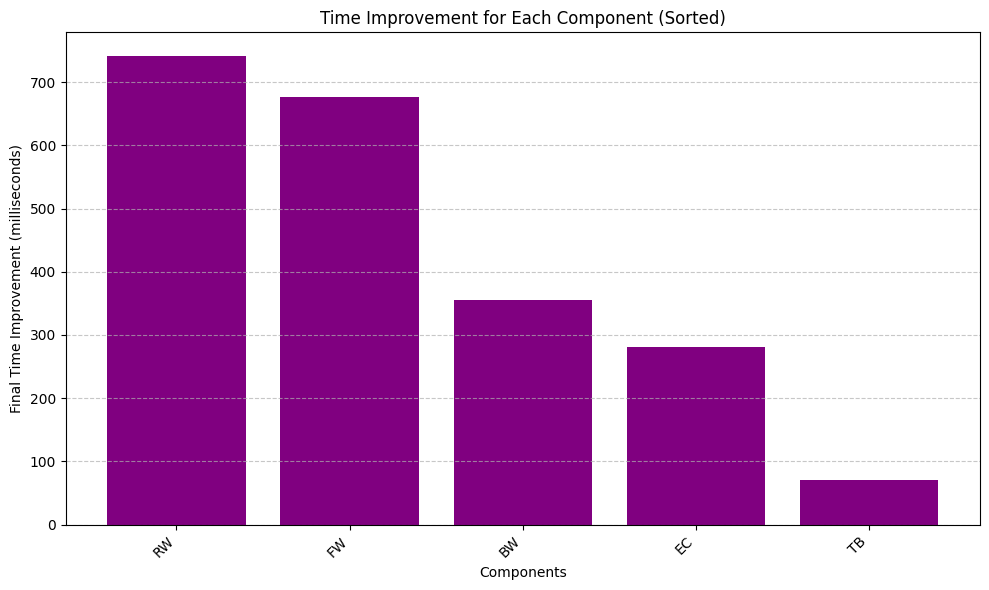

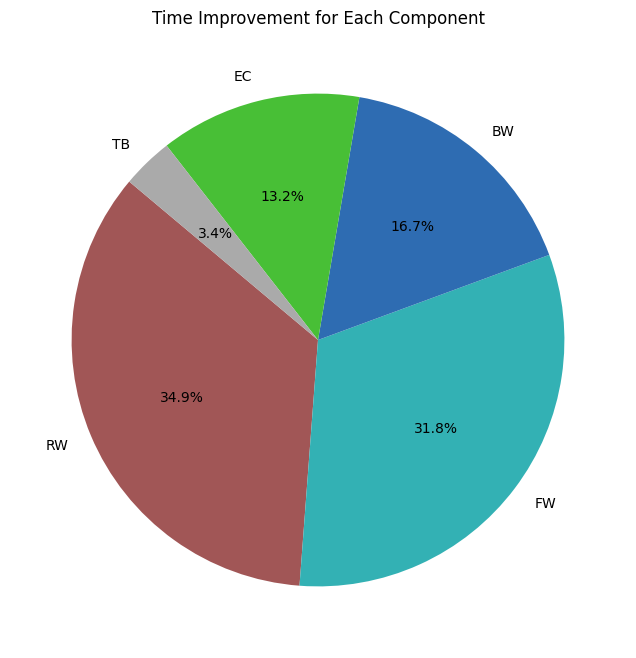

In [90]:
# Create a dictionary to store the total time improvement for each component
total_time_by_component = {component: 0.0 for component in WindTunnelParts}

# Update the dictionary with the total time improvement for each component
for (_, _, component), value in final_results.items():
    total_time_by_component[component] += value

# Sort the components by their total time improvement
sorted_components = sorted(WindTunnelParts, key=lambda component: total_time_by_component[component], reverse=True)

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(sorted_components))

time_improvement = [total_time_by_component[component] for component in sorted_components]

ax.bar(x, time_improvement, tick_label=sorted_components, color='purple')
ax.set_xlabel("Components")
ax.set_ylabel("Final Time Improvement (milliseconds)")
ax.set_title("Time Improvement for Each Component (Sorted)")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid

plt.show()

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8))

N = len(sorted_components)  

# Data for the pie chart
time_improvement_top_n = [total_time_by_component[component] for component in sorted_components[:N]]
components_top_n = sorted_components[:N]

ax.pie(time_improvement_top_n, labels=components_top_n, colors = piechart_colors, autopct='%1.1f%%', startangle=140)

# Add a title
ax.set_title('Time Improvement for Each Component'.format(N))

# Show the pie chart
plt.show()



We are doing the same, getting the Time / Money relation: 

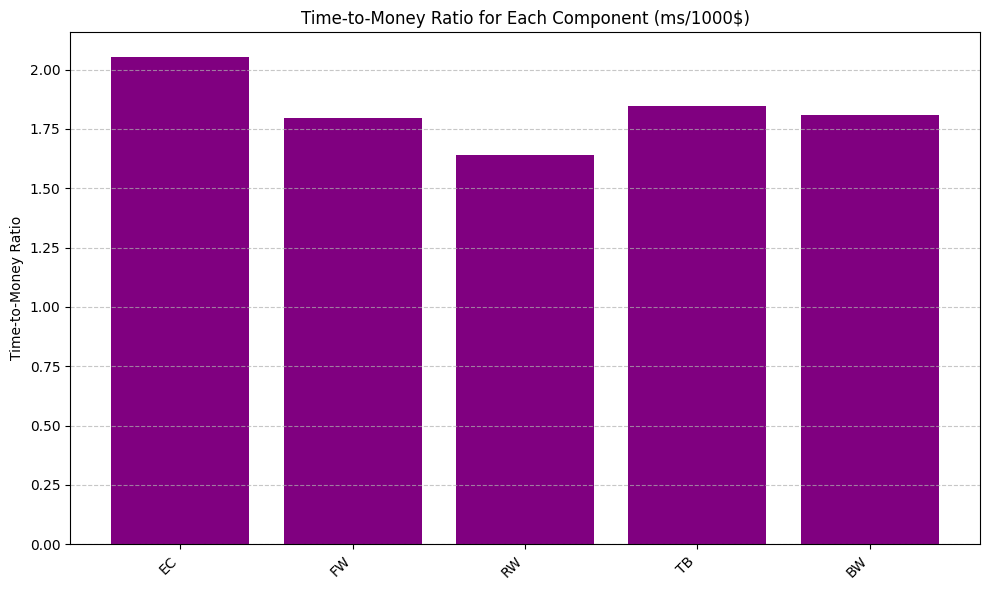

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Money Allocated Code
component_allocation = {}
for j in model.j:
    component_allocation[j] = sum(model.x[k, i, j].value * model.Cost[k, j] for k in model.k for i in model.i)

sorted_components_money = sorted(component_allocation, key=lambda component: -component_allocation[component])

# Time Improvement Code
total_time_by_component = {component: 0.0 for component in WindTunnelParts}
for (_, _, component), value in final_results.items():
    total_time_by_component[component] += value

sorted_components_time = sorted(WindTunnelParts, key=lambda component: total_time_by_component[component])

# Combine the two sorted lists
combined_components = list(set(sorted_components_money) | set(sorted_components_time))

# Compute time-to-money ratio for each component
time_money_ratio = [
    1000 * total_time_by_component.get(component, 0) / component_allocation.get(component, 1)
    for component in combined_components
]

# Bar Plot for Time-to-Money Ratio
fig, ax1 = plt.subplots(figsize=(10, 6))
x = np.arange(len(combined_components))

ax1.bar(x, time_money_ratio, tick_label=combined_components, color='purple')
ax1.set_ylabel("Time-to-Money Ratio")
ax1.set_title('Time-to-Money Ratio for Each Component (ms/1000$)')

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.show()




"FrontWing", "RearWing", "BodyWork", "TurningBane", "EngineCover"

# Part 1 Second Conclusion: 

We can see that the EngineCover (EC) is the part that gives the best time improvement, so the teams should focus to getting it. 
That piece does not give a large time improvement but has a low cost, so it could be really interesting to use it. 

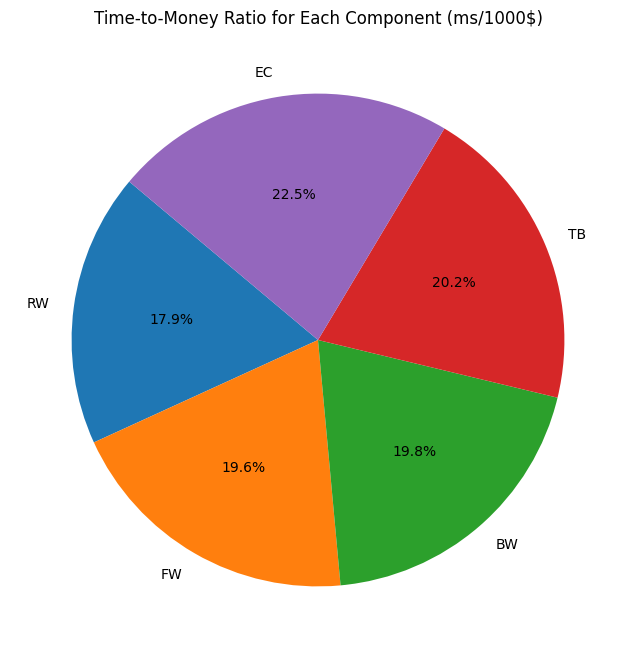

In [92]:
# Pie Chart for Time-to-Money Ratio
fig, ax2 = plt.subplots(figsize=(8, 8))
N = len(combined_components)
time_money_ratio_top_n = [time_money_ratio[i] for i in np.argsort(time_money_ratio)[-N:]]
components_top_n = [combined_components[i] for i in np.argsort(time_money_ratio)[-N:]]

ax2.pie(time_money_ratio_top_n, labels=components_top_n, autopct='%1.1f%%', startangle=140)

# Add a title
ax2.set_title('Time-to-Money Ratio for Each Component (ms/1000$)'.format(N))
plt.show()

Here we can see the distribution of the percentage that each 1000$ gives in time. We can see that the data is quite balance, what means that all the components has a price/improvement proportion that is quite similar. The difference between them is not so large in average. 

# Sensitivity
We are going to see which of the constraints that we have introduced in our model, are the ones that constraint it the most. I expect the budget of the Teams to be so, as the more money we allocate, the more time we improve. 

In [93]:
sensitivities = {}
for c in model.component_data_objects(Constraint, active=True):
    sensitivities[c.name] = model.dual[c]

print(sensitivities)

# Extract constraint names and their corresponding dual values
constraint_names = list(sensitivities.keys())
dual_values_list = list(sensitivities.values())

# Filter out constraints with zero dual values
non_zero_constraints = []
non_zero_dual_values = []
for name, value in zip(constraint_names, dual_values_list):
    if abs(value) > 1e-6:  # Adjust the tolerance as needed
        non_zero_constraints.append(name)
        non_zero_dual_values.append(value)


{'BudgetTeam[RedB]': 0.00161111111111111, 'BudgetTeam[AlphaTauri]': 0.0015037037037037, 'BudgetTeam[Haas]': 0.00142, 'BudgetTeam[Ferrari]': 0.00171666666666667, 'BudgetTeam[AlfaRomeo]': 0.001696, 'BudgetTeam[Mercedes]': 0.00177675807164971, 'BudgetTeam[Williams]': 0.00144137931034483, 'BudgetTeam[Alpine]': 0.00149321266968326, 'BudgetTeam[AstonMartin]': 0.00167741935483871, 'BudgetTeam[Mclaren]': 0.00181739130434783, 'BudgetTunnel[RedB,FW]': 0.0, 'BudgetTunnel[RedB,RW]': 0.0, 'BudgetTunnel[RedB,BW]': 0.0, 'BudgetTunnel[RedB,TB]': 0.0, 'BudgetTunnel[RedB,EC]': 0.000617460317460318, 'BudgetTunnel[AlphaTauri,FW]': 0.000418518518518519, 'BudgetTunnel[AlphaTauri,RW]': 0.0, 'BudgetTunnel[AlphaTauri,BW]': 7.12962962962965e-05, 'BudgetTunnel[AlphaTauri,TB]': 0.0, 'BudgetTunnel[AlphaTauri,EC]': 0.0, 'BudgetTunnel[Haas,FW]': 0.00046421052631579, 'BudgetTunnel[Haas,RW]': 0.0, 'BudgetTunnel[Haas,BW]': 0.00026, 'BudgetTunnel[Haas,TB]': 0.0, 'BudgetTunnel[Haas,EC]': 0.0, 'BudgetTunnel[Ferrari,FW]': 

Constraint: BudgetTeam[Mclaren], Dual Value: 0.00181739130434783
Constraint: BudgetTeam[Mercedes], Dual Value: 0.00177675807164971
Constraint: BudgetTeam[Ferrari], Dual Value: 0.00171666666666667
Constraint: BudgetTeam[AlfaRomeo], Dual Value: 0.001696
Constraint: BudgetTeam[AstonMartin], Dual Value: 0.00167741935483871


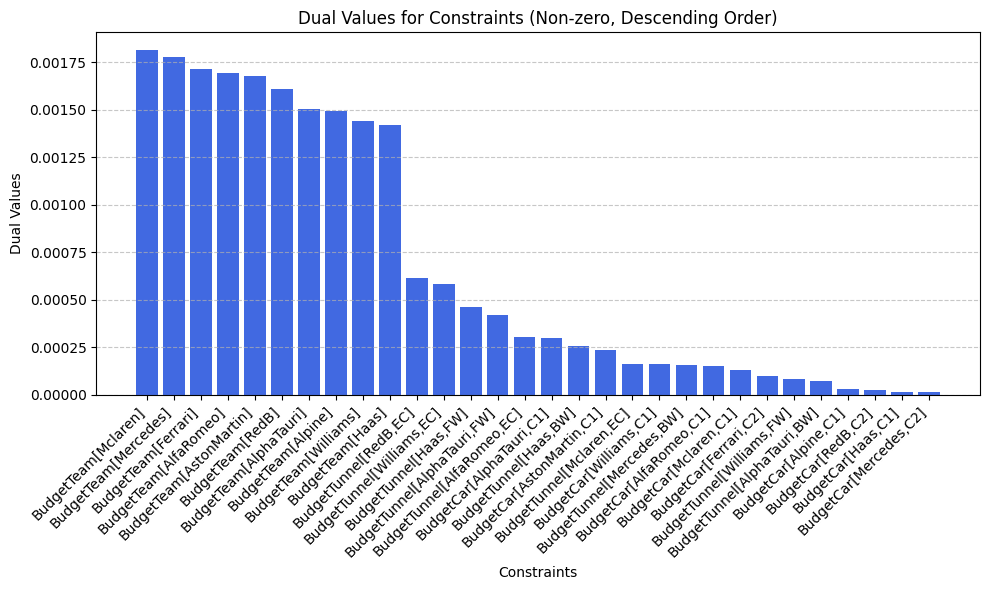

In [94]:
# Sort non-zero dual values and their corresponding constraint names in descending order
sorted_data = sorted(zip(non_zero_dual_values, non_zero_constraints), reverse=True)

sorted_non_zero_dual_values, sorted_non_zero_constraints = zip(*sorted_data)

# Display the top 5 constraints with the highest dual values
top_5_constraints = sorted_non_zero_constraints[:5]
top_5_dual_values = sorted_non_zero_dual_values[:5]

for constraint, dual_value in zip(top_5_constraints, top_5_dual_values):
    print(f"Constraint: {constraint}, Dual Value: {dual_value}")

# Create a bar plot for all non-zero dual values (optional)
plt.figure(figsize=(10, 6))
x = range(len(sorted_non_zero_constraints))

plt.bar(x, sorted_non_zero_dual_values, tick_label=sorted_non_zero_constraints, color='royalblue')
plt.xlabel("Constraints")
plt.ylabel("Dual Values")
plt.title("Dual Values for Constraints (Non-zero, Descending Order)")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid

plt.show()


The dual values, also know as shadow prices, are quite low for this case in this scale, but in the graph we can clearly see how each of the constraints group affects our model. 
The budget of the teams constraints the model more than twice any of the budget of the component of the tunnel parts. 
We can also see that the budget of the car does not affect as much for the total improvement of the time. This is because we do not care about in which car the money is invested. It can be in any of them, that the $ allocated will keep been the same. 

In [95]:
# Print the content of a constraint
specific_constraint = model.component("BudgetTeam")
specific_constraint.pprint()

BudgetTeam : Maximum Budget allowed for each Team
    Size=10, Index=k, Active=True
    Key         : Lower : Body                                                                                                                                                                                                                                                                            : Upper              : Active
      AlfaRomeo :  -Inf :                   1150*x[AlfaRomeo,C1,FW] + 1250*x[AlfaRomeo,C1,RW] + 860*x[AlfaRomeo,C1,BW] + 1625*x[AlfaRomeo,C1,TB] + 370*x[AlfaRomeo,C1,EC] + 1150*x[AlfaRomeo,C2,FW] + 1250*x[AlfaRomeo,C2,RW] + 860*x[AlfaRomeo,C2,BW] + 1625*x[AlfaRomeo,C2,TB] + 370*x[AlfaRomeo,C2,EC] :           138000.0 :   True
     AlphaTauri :  -Inf :           900*x[AlphaTauri,C1,FW] + 1350*x[AlphaTauri,C1,RW] + 800*x[AlphaTauri,C1,BW] + 2000*x[AlphaTauri,C1,TB] + 490*x[AlphaTauri,C1,EC] + 900*x[AlphaTauri,C2,FW] + 1350*x[AlphaTauri,C2,RW] + 800*x[AlphaTauri,C2,BW] + 2000*x[AlphaT

Here we can see the Budget Team Constraint that we have defined, obviously a bit complex due to the high number of teams and cars we have introduced to the model. 

# PART 2:
##  Using binary or integer variables

The FIA changes the rules of the sport each 3 years. The purpose of this is to adapt to new technologies, force the teams to change the car designs and allow other teams to be able to win making the sport more competitive. 
They have decided that for this "season" of years, the teams are going to be forced to train parts of the car in the Wind Tunnel in a consistent manner. Each Team is allow to decide in which piece they want to invest their money, but they will have to tune all the years that pieces constintently. The reason for this new measure is to reduce costs, as changing the configuration of the Wind Tunnel to train each piece of the car is quite expensive. 

The target is that if a Team, let´s say RedBull, thinks that the best optimal way to invest their money in updrading the car is to spend all the budget in Front Wing (FW) and Rear Wing (RW) for all the years, they will be able to tune their car for all the 3 years of the season only into this 2 components. 

The FIA has made a prediction for 2023, 2024 and 2025 of the money that the teams will invest to upgrade their cars. 
Notice that each year has a different budget depending on how well does the year go for the FIA in economic terms.  

The following data has been obtained by the FIA after computing for the 2023, 2024 and 2025 seasons, the optimal money investment of each of the teams. 
*Note: (This data is invented to avoid repeating the first part of the assignemnt 3 times) 

Year 2023 Data: 

In [96]:
random.seed(2023)  # I am going to set a seed so that each time I run the code, the output is consistent and so are the conclusions.  

MoneyInvestment2023 = {}

# Generate the dataset
for team in Teams:
    for car in Cars:
        # Define variations for each component for the current team and car considering the cost associated to each piece
        team_car_component_variations = {
            "FW": random.uniform(850, 9000),
            "RW": random.uniform(1230, 7670),
            "BW": random.uniform(2680, 6000),
            "TB": random.uniform(1700, 7000),
            "EC": random.uniform(500, 4500),
        }
        # I have defined a range for the Uniform distribution that is correlated to the different Cost of the components so that many components are select in different cars, and we have some variabilities. 

        for component in WindTunnelParts:
            original_value = 3 # The larger this value is, the more wider results we get, and larger will be the time improved.  
            variation = team_car_component_variations.get(component, 1); #print(variation)
            MoneyInvestment2023[(team, car, component)] = round(original_value * variation, 2)

# Print the modified dataset
total_money_invested_team_2023 = 0
for key, value in MoneyInvestment2023.items():
    total_money_invested_team_2023 += value 
    print(key, ":", value)
print(f"\nTotal money invested for 2025: {round(total_money_invested_team_2023,3)} $")


('Haas', 'C1', 'FW') : 11912.44
('Haas', 'C1', 'RW') : 22466.38
('Haas', 'C1', 'BW') : 16444.42
('Haas', 'C1', 'TB') : 10192.46
('Haas', 'C1', 'EC') : 8352.31
('Haas', 'C2', 'FW') : 10795.4
('Haas', 'C2', 'RW') : 5622.92
('Haas', 'C2', 'BW') : 9273.84
('Haas', 'C2', 'TB') : 9923.62
('Haas', 'C2', 'EC') : 9861.47
('AlphaTauri', 'C1', 'FW') : 20114.01
('AlphaTauri', 'C1', 'RW') : 9508.38
('AlphaTauri', 'C1', 'BW') : 10357.34
('AlphaTauri', 'C1', 'TB') : 20646.11
('AlphaTauri', 'C1', 'EC') : 3620.27
('AlphaTauri', 'C2', 'FW') : 2967.12
('AlphaTauri', 'C2', 'RW') : 10704.08
('AlphaTauri', 'C2', 'BW') : 14246.66
('AlphaTauri', 'C2', 'TB') : 16309.76
('AlphaTauri', 'C2', 'EC') : 10887.52
('AlfaRomeo', 'C1', 'FW') : 7435.5
('AlfaRomeo', 'C1', 'RW') : 22456.74
('AlfaRomeo', 'C1', 'BW') : 17010.31
('AlfaRomeo', 'C1', 'TB') : 13553.8
('AlfaRomeo', 'C1', 'EC') : 7534.04
('AlfaRomeo', 'C2', 'FW') : 4406.42
('AlfaRomeo', 'C2', 'RW') : 22189.04
('AlfaRomeo', 'C2', 'BW') : 13004.87
('AlfaRomeo', 'C2'

Year 2024 Data: 

In [97]:
random.seed(2024)  # I am going to set a seed so that each time I run the code, the output is consistent and so are the conclusions.  

MoneyInvestment2024 = {}

# Generate the dataset
for team in Teams:
    for car in Cars:
        # Define variations for each component for the current team and car considering the cost associated to each piece
        team_car_component_variations = {
            "FW": random.uniform(850, 9000),
            "RW": random.uniform(1230, 7670),
            "BW": random.uniform(2680, 6000),
            "TB": random.uniform(1700, 7000),
            "EC": random.uniform(500, 4500),
        }
        # I have defined a range for the Uniform distribution that is correlated to the different Cost of the components so that many components are select in different cars, and we have some variabilities. 

        for component in WindTunnelParts:
            original_value = 2.5 # The larger this value is, the more wider results we get, and larger will be the time improved.  
            variation = team_car_component_variations.get(component, 1); #print(variation)
            MoneyInvestment2024[(team, car, component)] = round(original_value * variation, 2)

# Print the modified dataset
total_money_invested_team_2024 = 0
for key, value in MoneyInvestment2024.items():
    total_money_invested_team_2024 += value 
    print(key, ":", value)
print(f"\nTotal money invested for 2025: {round(total_money_invested_team_2024,3)} $")


('Haas', 'C1', 'FW') : 11703.1
('Haas', 'C1', 'RW') : 14800.06
('Haas', 'C1', 'BW') : 9221.14
('Haas', 'C1', 'TB') : 16006.7
('Haas', 'C1', 'EC') : 5350.89
('Haas', 'C2', 'FW') : 16726.02
('Haas', 'C2', 'RW') : 7345.06
('Haas', 'C2', 'BW') : 8734.88
('Haas', 'C2', 'TB') : 15016.71
('Haas', 'C2', 'EC') : 6233.01
('AlphaTauri', 'C1', 'FW') : 10598.39
('AlphaTauri', 'C1', 'RW') : 14791.92
('AlphaTauri', 'C1', 'BW') : 14694.97
('AlphaTauri', 'C1', 'TB') : 8351.26
('AlphaTauri', 'C1', 'EC') : 8290.6
('AlphaTauri', 'C2', 'FW') : 12706.77
('AlphaTauri', 'C2', 'RW') : 14849.9
('AlphaTauri', 'C2', 'BW') : 14997.2
('AlphaTauri', 'C2', 'TB') : 6984.56
('AlphaTauri', 'C2', 'EC') : 8775.91
('AlfaRomeo', 'C1', 'FW') : 11671.36
('AlfaRomeo', 'C1', 'RW') : 14490.46
('AlfaRomeo', 'C1', 'BW') : 13936.83
('AlfaRomeo', 'C1', 'TB') : 6215.92
('AlfaRomeo', 'C1', 'EC') : 3376.11
('AlfaRomeo', 'C2', 'FW') : 10517.68
('AlfaRomeo', 'C2', 'RW') : 4016.61
('AlfaRomeo', 'C2', 'BW') : 9600.39
('AlfaRomeo', 'C2', 'T

Year 2025 Data: 

In [98]:
random.seed(2025)  # I am going to set a seed so that each time I run the code, the output is consistent and so are the conclusions.  

MoneyInvestment2025 = {}

# Generate the dataset
for team in Teams:
    for car in Cars:
        # Define variations for each component for the current team and car considering the cost associated to each piece
        team_car_component_variations = {
            "FW": random.uniform(850, 9000),
            "RW": random.uniform(1230, 7670),
            "BW": random.uniform(2680, 6000),
            "TB": random.uniform(1700, 7000),
            "EC": random.uniform(500, 4500),
        }
        # I have defined a range for the Uniform distribution that is correlated to the different Cost of the components so that many components are select in different cars, and we have some variabilities. 

        for component in WindTunnelParts:
            original_value = 1.7 # The larger this value is, the more wider results we get, and larger will be the time improved.  
            variation = team_car_component_variations.get(component, 1); #print(variation)
            MoneyInvestment2025[(team, car, component)] = round(original_value * variation, 2)

# Print the modified dataset
total_money_invested_team_2025 = 0
for key, value in MoneyInvestment2025.items():
    total_money_invested_team_2025 += value 
    print(key, ":", value)
print(f"\nTotal money invested for 2025: {round(total_money_invested_team_2025,3)} $")


('Haas', 'C1', 'FW') : 9172.66
('Haas', 'C1', 'RW') : 9161.71
('Haas', 'C1', 'BW') : 7251.61
('Haas', 'C1', 'TB') : 4451.3
('Haas', 'C1', 'EC') : 853.04
('Haas', 'C2', 'FW') : 14929.96
('Haas', 'C2', 'RW') : 8328.17
('Haas', 'C2', 'BW') : 4927.29
('Haas', 'C2', 'TB') : 6501.86
('Haas', 'C2', 'EC') : 1144.79
('AlphaTauri', 'C1', 'FW') : 12075.51
('AlphaTauri', 'C1', 'RW') : 12841.98
('AlphaTauri', 'C1', 'BW') : 5116.72
('AlphaTauri', 'C1', 'TB') : 3333.56
('AlphaTauri', 'C1', 'EC') : 1039.51
('AlphaTauri', 'C2', 'FW') : 8514.09
('AlphaTauri', 'C2', 'RW') : 10618.16
('AlphaTauri', 'C2', 'BW') : 5652.42
('AlphaTauri', 'C2', 'TB') : 4596.01
('AlphaTauri', 'C2', 'EC') : 5665.96
('AlfaRomeo', 'C1', 'FW') : 15039.89
('AlfaRomeo', 'C1', 'RW') : 12385.45
('AlfaRomeo', 'C1', 'BW') : 8160.82
('AlfaRomeo', 'C1', 'TB') : 11190.74
('AlfaRomeo', 'C1', 'EC') : 3260.4
('AlfaRomeo', 'C2', 'FW') : 14083.21
('AlfaRomeo', 'C2', 'RW') : 8612.41
('AlfaRomeo', 'C2', 'BW') : 7638.37
('AlfaRomeo', 'C2', 'TB') :

Now we are going to generate the expected Final Time improvement that we will have if that piece is trained during the 3 years in a consecutive manner. 

In [99]:
random.seed(200)  # I am going to set a seed so that each time I run the code, the output is consistent and so are the conclusions.  

FinalImprovementOfPartByCar = {}

# Generate the dataset
for team in Teams:
    for car in Cars:
        # Define variations for each component for the current team and car considering the cost associated to each piece
        team_car_component_variations = {
            "FW": random.uniform(0.85, 1.15),
            "RW": random.uniform(1.25, 1.35),
            "BW": random.uniform(0.75, 0.95),
            "TB": random.uniform(1.64, 1.88),
            "EC": random.uniform(0.36, 0.53),
        }
        # I have defined a range for the Uniform distribution that is correlated to the different Cost of the components so that many components are select in different cars, and we have some variabilities. 

        for component in WindTunnelParts:
            original_value = 30 # The larger this value is, the more wider results we get, and larger will be the time improved.  
            variation = team_car_component_variations.get(component, 1); #print(variation)
            FinalImprovementOfPartByCar[(team, car, component)] = round(original_value * variation, 2)


# Print the modified dataset
total_time_improved = 0
for key, value in FinalImprovementOfPartByCar.items():
    total_time_improved += value 
    print(key, ":", value)
print(f"\nTotal time improved if all components could be used: {round(total_time_improved,3)} (ms)")    

('Haas', 'C1', 'FW') : 25.91
('Haas', 'C1', 'RW') : 38.11
('Haas', 'C1', 'BW') : 26.75
('Haas', 'C1', 'TB') : 50.23
('Haas', 'C1', 'EC') : 15.19
('Haas', 'C2', 'FW') : 27.9
('Haas', 'C2', 'RW') : 37.53
('Haas', 'C2', 'BW') : 25.14
('Haas', 'C2', 'TB') : 50.4
('Haas', 'C2', 'EC') : 10.88
('AlphaTauri', 'C1', 'FW') : 28.0
('AlphaTauri', 'C1', 'RW') : 38.88
('AlphaTauri', 'C1', 'BW') : 23.66
('AlphaTauri', 'C1', 'TB') : 55.34
('AlphaTauri', 'C1', 'EC') : 12.33
('AlphaTauri', 'C2', 'FW') : 31.81
('AlphaTauri', 'C2', 'RW') : 38.55
('AlphaTauri', 'C2', 'BW') : 23.11
('AlphaTauri', 'C2', 'TB') : 52.33
('AlphaTauri', 'C2', 'EC') : 14.3
('AlfaRomeo', 'C1', 'FW') : 29.88
('AlfaRomeo', 'C1', 'RW') : 39.43
('AlfaRomeo', 'C1', 'BW') : 23.23
('AlfaRomeo', 'C1', 'TB') : 50.21
('AlfaRomeo', 'C1', 'EC') : 11.46
('AlfaRomeo', 'C2', 'FW') : 29.93
('AlfaRomeo', 'C2', 'RW') : 40.08
('AlfaRomeo', 'C2', 'BW') : 24.8
('AlfaRomeo', 'C2', 'TB') : 55.11
('AlfaRomeo', 'C2', 'EC') : 11.37
('Mclaren', 'C1', 'FW') :

# Binary Model Definition

\begin{align*}
& \text{Variables:} \\
& x_{ijk} \geq 0, \quad \forall k \in \text{Teams}, \forall i \in \text{Cars}, \forall j \in \text{WindTunnelParts} \\
& \text{where } x_{ijk} \text{ represents whether on team } k \text{ with car } i \text{ piece } j \text{ is tuned on the tunnel for the whole season or not.} \\
& \text{with } x \in \mathbb{R}^{\geq 0}
\end{align*}


\begin{align*}


& \text{maximize } \sum_{k \in \text{Teams}} \sum_{i \in \text{Cars}} \sum_{j \in \text{WindTunnelParts}} \text{partImprove}[k,i,j] \cdot x[k,i,j] \\

& \text{subject to} \\

& \quad x[k,i,j] \in \{0, 1\} && \forall k \in \text{Teams}, \forall i \in \text{Cars}, \forall j \in \text{WindTunnelParts} \\

& \text{Budget 2023:} \quad \sum_{k \in \text{Teams}} \sum_{i \in \text{Cars}} \sum_{j \in \text{WindTunnelParts}} \text{MoneyInvestment2023}[k,i,j] \cdot x[k,i,j] \leq \text{budget2023}, \quad \forall k \in \text{Teams}, \forall i \in \text{Cars}, \forall j \in \text{WindTunnelParts} \\
\\
& \text{Budget 2024:} \quad \sum_{k \in \text{Teams}} \sum_{i \in \text{Cars}} \sum_{j \in \text{WindTunnelParts}} \text{MoneyInvestment2024}[k,i,j] \cdot x[k,i,j] \leq \text{budget2024}, \quad \forall k \in \text{Teams}, \forall i \in \text{Cars}, \forall j \in \text{WindTunnelParts} \\
\\
& \text{Budget 2025:} \quad \sum_{k \in \text{Teams}} \sum_{i \in \text{Cars}} \sum_{j \in \text{WindTunnelParts}} \text{MoneyInvestment2025}[k,i,j] \cdot x[k,i,j] \leq \text{budget2025}, \quad \forall k \in \text{Teams}, \forall i \in \text{Cars}, \forall j \in \text{WindTunnelParts}
\end{align*}

- The model variable is binary. Denotes whether piece j of car i, team k is tunned for the whole season on the Wind Tunnel or not.
- Now we forget about costs, team budgets and so on as we have been provided with that information. 
- We have a budget that we can invest each of the years (2023, 2024, 2025), and we cannot exceed it. 

Budget for each of the Years. This comes directly from the money that the FIA has generated in the previous years. 

In [100]:
budget2023 = 900000 
budget2024 = 650000
budget2025 = 400000

In [101]:
model_bin = ConcreteModel()

# Using binary or integer variables
model_bin.i = Set(initialize=Cars, doc='Cars' )
model_bin.j = Set(initialize = WindTunnelParts, doc="WindTunnelPart")
model_bin.k = Set(initialize = Teams, doc="Teams")

# # Parameters
model_bin.FinalPartImprove = Param(model_bin.k, model_bin.i, model_bin.j, initialize=FinalImprovementOfPartByCar, within=NonNegativeReals,doc="Final Time Improvement of a car if that part is used on wind tunnel all the years.")
model_bin.MoneyInvestment2023 = Param(model_bin.k, model_bin.i, model_bin.j, rule=MoneyInvestment2023, doc='Cost of part j, car i, team k, on Year 2023')
model_bin.MoneyInvestment2024 = Param(model_bin.k, model_bin.i, model_bin.j, rule=MoneyInvestment2024, doc='Cost of part j, car i, team k, on Year 2024')
model_bin.MoneyInvestment2025 = Param(model_bin.k, model_bin.i, model_bin.j, rule=MoneyInvestment2025, doc='Cost of part j, car i, team k, on Year 2025')


# variables
model_bin.x = Var(model_bin.k, model_bin.i, model_bin.j, doc = "Whether piece j of car i, team k is tunned for the whole season on the Wind Tunnel or not", within = Binary)

In [102]:
# objective function
def objective_rule(model):
    return sum(model.FinalPartImprove[k,i,j]*model.x[k,i,j] for k in model.k for i in model.i for j in model.j)

model_bin.obj = Objective(rule = objective_rule, sense = maximize, doc = "Total Time Improvement in seconds")

In [103]:
 # constraints
def budget2023_rule(model):
    return sum((model.MoneyInvestment2023[k,i,j] * model.x[k,i,j]) for k in model.k for i in model.i for j in model.j) <= budget2023
model_bin.budget2023 = Constraint(rule=budget2023_rule, doc="Maximum Budget allowed for each Wind Tunnel Part j,  of car i, team k on Year 2023")

def budget2024_rule(model):
    return sum((model.MoneyInvestment2024[k,i,j] * model.x[k,i,j]) for k in model.k for i in model.i for j in model.j) <= budget2024
model_bin.budget2024 = Constraint(rule=budget2024_rule, doc="Maximum Budget allowed for each Wind Tunnel Part j,  of car i, team k on Year 2024")

def budget2025_rule(model):
    return sum(model.MoneyInvestment2025[k,i,j] * model.x[k,i,j] for k in model.k for i in model.i for j in model.j) <= budget2025
model_bin.budget2025 = Constraint(rule=budget2025_rule, doc="Maximum Budget allowed for each Wind Tunnel Part j,  of car i, team k on Year 2025")

In [104]:
Solver = SolverFactory('glpk')
#Solver = SolverFactory('gurobi') # This is also a quite known solver

Results = Solver.solve(model_bin)

# Display solution
display(model_bin)

Model unknown

  Variables:
    x : Whether piece j of car i, team k is tunned for the whole season on the Wind Tunnel or not
        Size=100, Index=x_index
        Key                         : Lower : Value : Upper : Fixed : Stale : Domain
          ('AlfaRomeo', 'C1', 'BW') :     0 :   0.0 :     1 : False : False : Binary
          ('AlfaRomeo', 'C1', 'EC') :     0 :   1.0 :     1 : False : False : Binary
          ('AlfaRomeo', 'C1', 'FW') :     0 :   0.0 :     1 : False : False : Binary
          ('AlfaRomeo', 'C1', 'RW') :     0 :   0.0 :     1 : False : False : Binary
          ('AlfaRomeo', 'C1', 'TB') :     0 :   1.0 :     1 : False : False : Binary
          ('AlfaRomeo', 'C2', 'BW') :     0 :   0.0 :     1 : False : False : Binary
          ('AlfaRomeo', 'C2', 'EC') :     0 :   1.0 :     1 : False : False : Binary
          ('AlfaRomeo', 'C2', 'FW') :     0 :   0.0 :     1 : False : False : Binary
          ('AlfaRomeo', 'C2', 'RW') :     0 :   1.0 :     1 : False : False :

In [105]:
print(f"Time improvement by using all the components: {model_bin.obj()} milliseconds") # 15+8ms

Time improvement by using all the components: 2400.2400000000007 milliseconds


We can see that by investing a bit less than 2 million euros, we get 2.4 seconds of total improvement for the 3 years. 

# Binary Budget Allocation: 

In [106]:
#Get Time Improvement for each car and money spend on each car: 

part_quantities = {}  # Create an empty dictionary to store variable values
total_sum_for_car = {}
total_sum_for_team = {}

for k in model_bin.k:
    for i in model_bin.i:
        for j in model_bin.j:
            part_quantities[(k, i, j)] = model_bin.x[k,i, j].value     * (model_bin.MoneyInvestment2023[k,i,j] + model_bin.MoneyInvestment2024[k,i,j] + model_bin.MoneyInvestment2025[k,i,j])
            total_sum_for_car[k,i]     = sum(model_bin.x[k, i, j].value* (model_bin.MoneyInvestment2023[k,i,j] + model_bin.MoneyInvestment2024[k,i,j] + model_bin.MoneyInvestment2025[k,i,j]) for j in model_bin.j)
            total_sum_for_team[k]      = sum(model_bin.x[k, i, j].value* (model_bin.MoneyInvestment2023[k,i,j] + model_bin.MoneyInvestment2024[k,i,j] + model_bin.MoneyInvestment2025[k,i,j]) for i in model_bin.i for j in model_bin.j)

print("***** Budget Allocated of each Piece of each car of each Team *****")
for (k,i, j), value in part_quantities.items():
    if(value>0):
        print(f"Money Invested in [{k}, {i}, {j}] = {value} $")

    

***** Budget Allocated of each Piece of each car of each Team *****
Money Invested in [Haas, C1, RW] = 46428.15 $
Money Invested in [Haas, C1, BW] = 32917.17 $
Money Invested in [Haas, C1, TB] = 30650.46 $
Money Invested in [Haas, C1, EC] = 14556.240000000002 $
Money Invested in [Haas, C2, RW] = 21296.15 $
Money Invested in [Haas, C2, BW] = 22936.010000000002 $
Money Invested in [Haas, C2, TB] = 31442.190000000002 $
Money Invested in [Haas, C2, EC] = 17239.27 $
Money Invested in [AlphaTauri, C1, BW] = 30169.03 $
Money Invested in [AlphaTauri, C1, TB] = 32330.930000000004 $
Money Invested in [AlphaTauri, C1, EC] = 12950.380000000001 $
Money Invested in [AlphaTauri, C2, RW] = 36172.14 $
Money Invested in [AlphaTauri, C2, TB] = 27890.33 $
Money Invested in [AlfaRomeo, C1, TB] = 30960.46 $
Money Invested in [AlfaRomeo, C1, EC] = 14170.55 $
Money Invested in [AlfaRomeo, C2, RW] = 34818.06 $
Money Invested in [AlfaRomeo, C2, TB] = 32244.949999999997 $
Money Invested in [AlfaRomeo, C2, EC] = 

If any component is not shown here, it is because the money allocated it´s zero. 

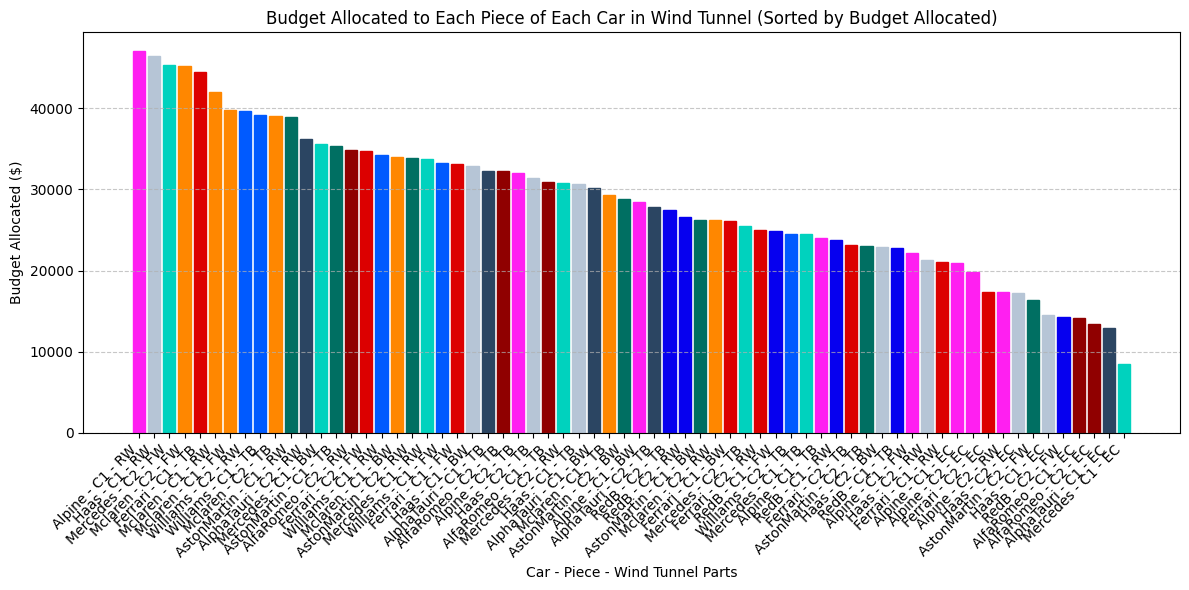

In [107]:
# Filter out items with zero budget allocation
non_zero_part_quantities = {k: v for k, v in part_quantities.items() if v != 0}

# Sort the filtered dictionary by value in descending order
sorted_part_quantities = {k: v for k, v in sorted(non_zero_part_quantities.items(), key=lambda item: item[1], reverse=True)}

# Extract the values (budget allocated)
values = list(sorted_part_quantities.values())

# Convert the keys to strings for plotting
keys_as_strings = [f"{k[0]} - {k[1]} - {k[2]}" for k in sorted_part_quantities.keys()]

# Create a bar plot with colors
plt.figure(figsize=(12, 6))
bars = plt.bar(keys_as_strings, values)
for k in sorted_part_quantities.keys():
    team = k[0]
    bars[keys_as_strings.index(f"{k[0]} - {k[1]} - {k[2]}")].set_color(team_colors[team])

plt.xlabel("Car - Piece - Wind Tunnel Parts")
plt.ylabel("Budget Allocated ($)")
plt.title("Budget Allocated to Each Piece of Each Car in Wind Tunnel (Sorted by Budget Allocated)")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Display the plot
plt.tight_layout()
plt.show()

Now, as we are forced to invest in three years consecutively and the budget is increased, each car is tunned by lot of different parts. Alpine is the one that allocates the highest amount of money, 50.000 $, to the Rear Wing of their first car. Will see if that investment is retrieved or not.

In [108]:
print("***** Budget Allocated To each Car of each Team *****")

for i, total_sum in total_sum_for_car.items():
    print(f"Money invested in {i} on the Wind Tunnel is: {total_sum} $")


***** Budget Allocated To each Car of each Team *****
Money invested in ('Haas', 'C1') on the Wind Tunnel is: 124552.02 $
Money invested in ('Haas', 'C2') on the Wind Tunnel is: 92913.62000000001 $
Money invested in ('AlphaTauri', 'C1') on the Wind Tunnel is: 75450.34000000001 $
Money invested in ('AlphaTauri', 'C2') on the Wind Tunnel is: 64062.47 $
Money invested in ('AlfaRomeo', 'C1') on the Wind Tunnel is: 45131.009999999995 $
Money invested in ('AlfaRomeo', 'C2') on the Wind Tunnel is: 80430.98 $
Money invested in ('Mclaren', 'C1') on the Wind Tunnel is: 145284.62 $
Money invested in ('Mclaren', 'C2') on the Wind Tunnel is: 110527.04000000001 $
Money invested in ('Williams', 'C1') on the Wind Tunnel is: 106734.72 $
Money invested in ('Williams', 'C2') on the Wind Tunnel is: 64157.079999999994 $
Money invested in ('AstonMartin', 'C1') on the Wind Tunnel is: 100614.78 $
Money invested in ('AstonMartin', 'C2') on the Wind Tunnel is: 102187.23999999999 $
Money invested in ('Mercedes',

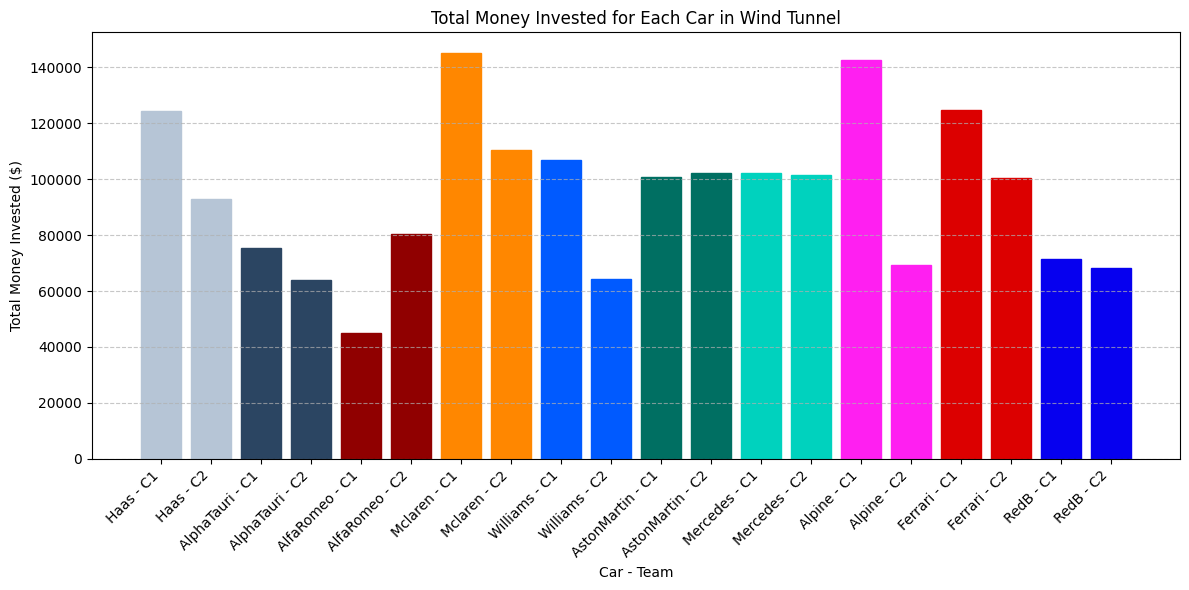

In [109]:
# Assuming you have already executed the code to get total_sum_for_car

# Extract the values (total money spent for each car)
car_values = list(total_sum_for_car.values())

# Convert the keys to strings for plotting
car_keys_as_strings = [f"{k[0]} - {k[1]}" for k in total_sum_for_car.keys()]

# Create a bar plot with colors
plt.figure(figsize=(12, 6))
car_bars = plt.bar(car_keys_as_strings, car_values)
for k in total_sum_for_car.keys():
    team = k[0]
    car_bars[car_keys_as_strings.index(f"{k[0]} - {k[1]}")].set_color(team_colors[team])

plt.xlabel("Car - Team")
plt.ylabel("Total Money Invested ($)")
plt.title("Total Money Invested for Each Car in Wind Tunnel")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Display the plot
plt.tight_layout()
plt.show()


Now, we can see bigger differences that in the previous case. For this second part, I decided to remove the constraint of the budget for each car. As each car has its own investment capabilities, the teams are the ones that decide how to split the money between them. 
Mercedes and Aston Martin split the money equally while Alfa Romeo has a huge difference. 

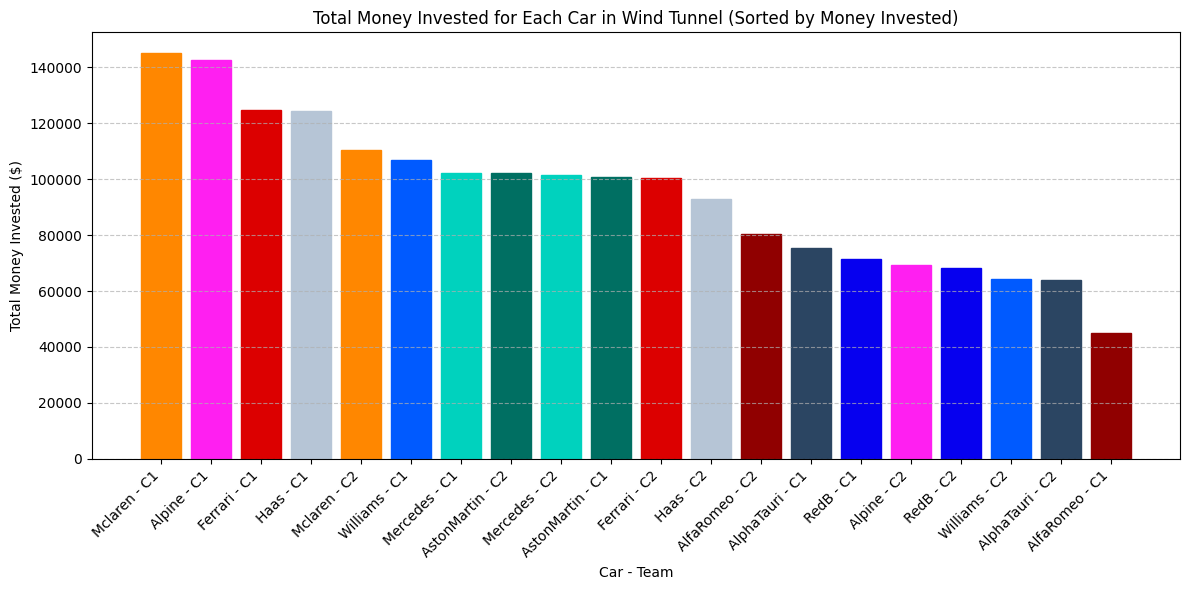

In [110]:
# Assuming you have already executed the code to get total_sum_for_car

# Extract the values (total money spent for each car)
car_values = list(total_sum_for_car.values())

# Sort the data by total money invested in descending order
sorted_car_data = sorted(zip(total_sum_for_car.keys(), car_values), key=lambda x: x[1], reverse=True)
sorted_car_keys, sorted_car_values = zip(*sorted_car_data)

# Create a sorted bar plot
plt.figure(figsize=(12, 6))
sorted_car_bars = plt.bar([f"{k[0]} - {k[1]}" for k in sorted_car_keys], sorted_car_values)
for k in sorted_car_keys:
    team = k[0]
    sorted_car_bars[[f"{k[0]} - {k[1]}" for k in sorted_car_keys].index(f"{k[0]} - {k[1]}")].set_color(team_colors[team])

plt.xlabel("Car - Team")
plt.ylabel("Total Money Invested ($)")
plt.title("Total Money Invested for Each Car in Wind Tunnel (Sorted by Money Invested)")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Display the sorted plot
plt.tight_layout()
plt.show()



Same plot as before but sorted by individual cars instead of grouping it by teams. The Car 1 of Mclaren is the one that receives more money from all the grid!

In [111]:
print("***** Budget Allocated To each Team *****")

total_money_invested_team = 0
for i, total_sum in total_sum_for_team.items():
    print(f"Money invested in {i} on the Wind Tunnel is: {total_sum} $")
    total_money_invested_team += total_sum

print("\nTotal money invested:",round(total_money_invested_team,3), "$ Out of total available budget: ", budget2023+budget2024+budget2025, "$")


***** Budget Allocated To each Team *****
Money invested in Haas on the Wind Tunnel is: 217465.64 $
Money invested in AlphaTauri on the Wind Tunnel is: 139512.81 $
Money invested in AlfaRomeo on the Wind Tunnel is: 125561.98999999999 $
Money invested in Mclaren on the Wind Tunnel is: 255811.66 $
Money invested in Williams on the Wind Tunnel is: 170891.8 $
Money invested in AstonMartin on the Wind Tunnel is: 202802.02 $
Money invested in Mercedes on the Wind Tunnel is: 203837.16 $
Money invested in Alpine on the Wind Tunnel is: 211878.08000000002 $
Money invested in Ferrari on the Wind Tunnel is: 225277.27000000002 $
Money invested in RedB on the Wind Tunnel is: 139817.3 $

Total money invested: 1892855.73 $ Out of total available budget:  1950000 $


We can see in the above data that we could not spend all the money, as to do so, we need to have full budget, that is not the case. We almost reach the top available money to invest so it is quite optimal. 

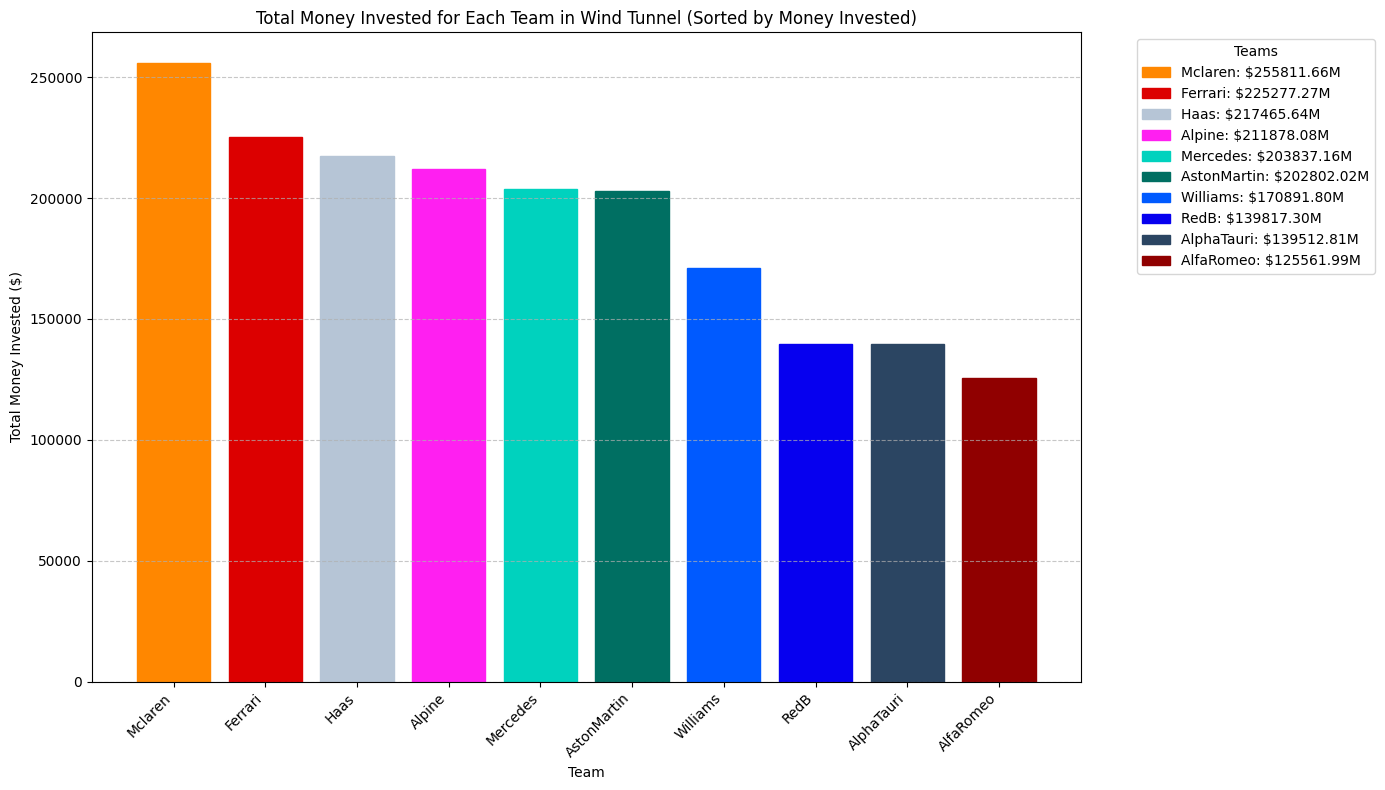

In [112]:
# Sort the data by total money invested for each team in descending order
team_values = list(total_sum_for_team.values())

sorted_team_data = sorted(zip(total_sum_for_team.keys(), team_values), key=lambda x: x[1], reverse=True)
sorted_team_keys, sorted_team_values = zip(*sorted_team_data)

# Create a sorted bar plot
plt.figure(figsize=(14, 8))
sorted_team_bars = plt.bar(sorted_team_keys, sorted_team_values)
for k in sorted_team_keys:
    sorted_team_bars[sorted_team_keys.index(k)].set_color(team_colors[k])

plt.xlabel("Team")
plt.ylabel("Total Money Invested ($)")
plt.title("Total Money Invested for Each Team in Wind Tunnel (Sorted by Money Invested)")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Add legend with team labels
legend_labels = [f"{team}: ${value:.2f}M" for team, value in zip(sorted_team_keys, sorted_team_values)]
plt.legend(sorted_team_bars, legend_labels, title="Teams", bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the sorted plot
plt.tight_layout()
plt.show()


The team that spends the highest amount is Mclaren, as they were provided better possibilities. They spend 255k$, while Alfa Romeo only spends the exact half, 125k $. This will have huge consecuencies on the improvement of each of the teams. 

# Binary Time Improvements
Now we are going to plot as with the money, the Time Improvement for all the pieces, cars and teams

In [113]:
#Get Time Improvement for each car and money spend on each car: 

part_quantities = {}  # Create an empty dictionary to store variable values
total_time_for_car = {}
total_time_for_team = {}

for k in model_bin.k:
    for i in model_bin.i:
        for j in model_bin.j:
            part_quantities[(k, i, j)] = model_bin.x[k,i, j].value * model_bin.FinalPartImprove[k,i,j]
            total_time_for_car[k,i] = sum(model_bin.x[k, i, j].value* model_bin.FinalPartImprove[k,i,j] for j in model_bin.j)
            total_time_for_team[k] = sum(model_bin.x[k, i, j].value* model_bin.FinalPartImprove[k,i,j] for i in model_bin.i for j in model_bin.j)

print("***** Time Improvement of each Piece of each car of each Team *****")
for (k,i, j), value in part_quantities.items():
    if(value>0):
        print(f"Time improved with [{k}, {i}, {j}] = {value} (ms)")

***** Time Improvement of each Piece of each car of each Team *****
Time improved with [Haas, C1, RW] = 38.11 (ms)
Time improved with [Haas, C1, BW] = 26.75 (ms)
Time improved with [Haas, C1, TB] = 50.23 (ms)
Time improved with [Haas, C1, EC] = 15.19 (ms)
Time improved with [Haas, C2, RW] = 37.53 (ms)
Time improved with [Haas, C2, BW] = 25.14 (ms)
Time improved with [Haas, C2, TB] = 50.4 (ms)
Time improved with [Haas, C2, EC] = 10.88 (ms)
Time improved with [AlphaTauri, C1, BW] = 23.66 (ms)
Time improved with [AlphaTauri, C1, TB] = 55.34 (ms)
Time improved with [AlphaTauri, C1, EC] = 12.33 (ms)
Time improved with [AlphaTauri, C2, RW] = 38.55 (ms)
Time improved with [AlphaTauri, C2, TB] = 52.33 (ms)
Time improved with [AlfaRomeo, C1, TB] = 50.21 (ms)
Time improved with [AlfaRomeo, C1, EC] = 11.46 (ms)
Time improved with [AlfaRomeo, C2, RW] = 40.08 (ms)
Time improved with [AlfaRomeo, C2, TB] = 55.11 (ms)
Time improved with [AlfaRomeo, C2, EC] = 11.37 (ms)
Time improved with [Mclaren, C1,

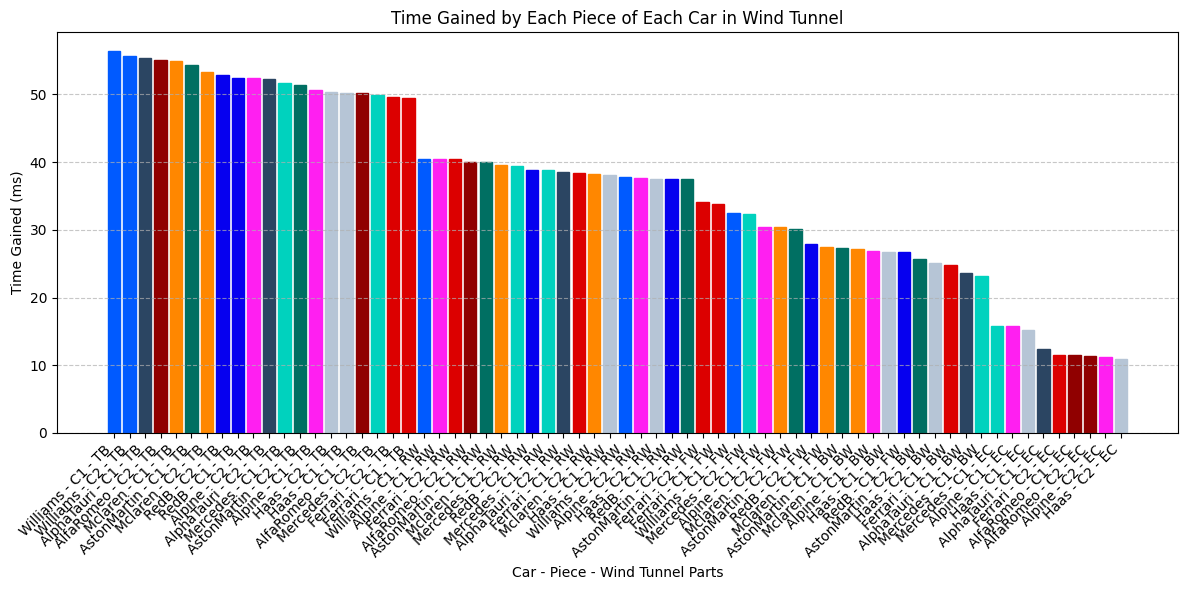

In [114]:
# Filter out items with zero budget allocation
non_zero_part_quantities = {k: v for k, v in part_quantities.items() if v != 0}

# Sort the filtered dictionary by value in descending order
sorted_part_quantities = {k: v for k, v in sorted(non_zero_part_quantities.items(), key=lambda item: item[1], reverse=True)}

# Extract the values (budget allocated)
values = list(sorted_part_quantities.values())

# Convert the keys to strings for plotting
keys_as_strings = [f"{k[0]} - {k[1]} - {k[2]}" for k in sorted_part_quantities.keys()]

# Create a bar plot with colors
plt.figure(figsize=(12, 6))
bars = plt.bar(keys_as_strings, values)
for k in sorted_part_quantities.keys():
    team = k[0]
    bars[keys_as_strings.index(f"{k[0]} - {k[1]} - {k[2]}")].set_color(team_colors[team])

plt.xlabel("Car - Piece - Wind Tunnel Parts")
plt.ylabel("Time Gained (ms)")
plt.title("Time Gained by Each Piece of Each Car in Wind Tunnel")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Display the plot
plt.tight_layout()
plt.show()

In part one we obtained the expected results, that were to find here that the most expensive component is the one giving the best result, but here, as we are conditioned to train that part in the car for 3 years in a row, the optimal piece is not found here. 
We expected to see Alpine´s Rear Wing for the Car 1 that was 50k$, but instead we are seeing that the best improvement is for Williams team in both Cars 1 and 2, by using the TurningBane component, which price was a bit less than 40k$. 

In [115]:
print("***** Time Improved on each Car of each Team *****")

for i, total_sum in total_time_for_car.items():
    print(f"Time Improvement in {i} on the Wind Tunnel is: {total_sum} milliseconds")


***** Time Improved on each Car of each Team *****
Time Improvement in ('Haas', 'C1') on the Wind Tunnel is: 130.28 milliseconds
Time Improvement in ('Haas', 'C2') on the Wind Tunnel is: 123.94999999999999 milliseconds
Time Improvement in ('AlphaTauri', 'C1') on the Wind Tunnel is: 91.33 milliseconds
Time Improvement in ('AlphaTauri', 'C2') on the Wind Tunnel is: 90.88 milliseconds
Time Improvement in ('AlfaRomeo', 'C1') on the Wind Tunnel is: 61.67 milliseconds
Time Improvement in ('AlfaRomeo', 'C2') on the Wind Tunnel is: 106.56 milliseconds
Time Improvement in ('Mclaren', 'C1') on the Wind Tunnel is: 149.17000000000002 milliseconds
Time Improvement in ('Mclaren', 'C2') on the Wind Tunnel is: 121.96000000000001 milliseconds
Time Improvement in ('Williams', 'C1') on the Wind Tunnel is: 129.37 milliseconds
Time Improvement in ('Williams', 'C2') on the Wind Tunnel is: 93.47999999999999 milliseconds
Time Improvement in ('AstonMartin', 'C1') on the Wind Tunnel is: 121.71000000000001 milli

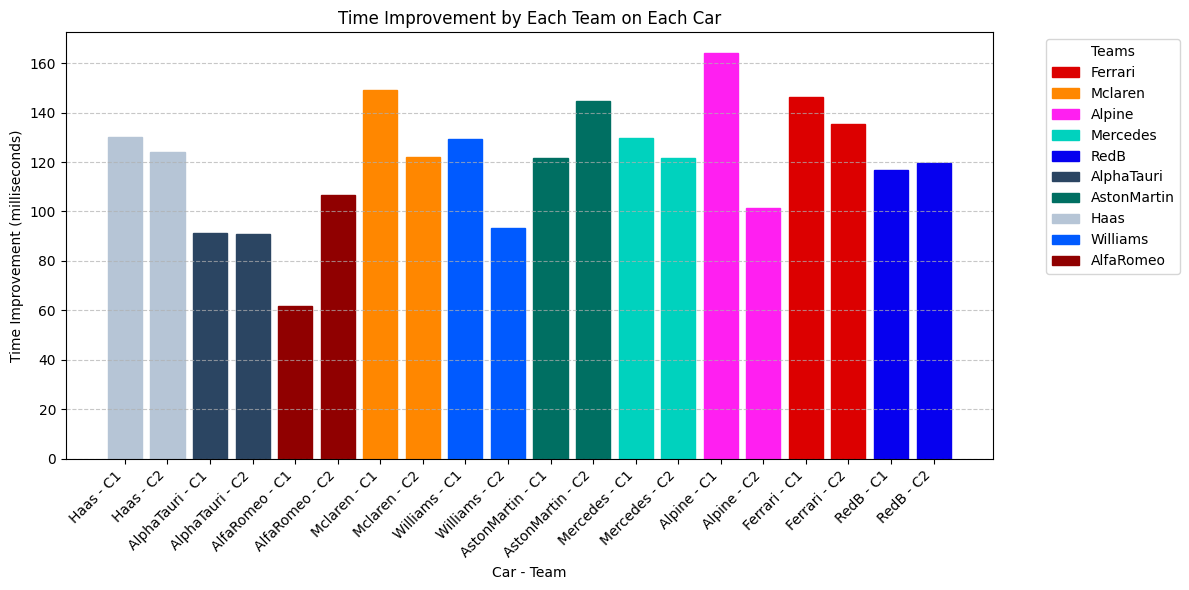

In [121]:
# Extract the values (total money spent for each car)
car_values = list(total_time_for_car.values())

# Convert the keys to strings for plotting
car_keys_as_strings = [f"{k[0]} - {k[1]}" for k in total_sum_for_car.keys()]

# Create a bar plot with colors
plt.figure(figsize=(12, 6))
car_bars = plt.bar(car_keys_as_strings, car_values)
for k in total_sum_for_car.keys():
    team = k[0]
    car_bars[car_keys_as_strings.index(f"{k[0]} - {k[1]}")].set_color(team_colors[team])

plt.xlabel("Car - Team")
plt.ylabel("Time Improvement (milliseconds)")
plt.title("Time Improvement by Each Team on Each Car")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Add legend with team labels using proxy artists
legend_handles = [Patch(color=team_colors[team], label=team) for team in legend_labels]
plt.legend(handles=legend_handles, title="Teams", bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


So, if we compare with the money allocated, the graph is quite similar. Mercedes and Aston Martin were more equilibrated but here they spend more on one car than the other. 

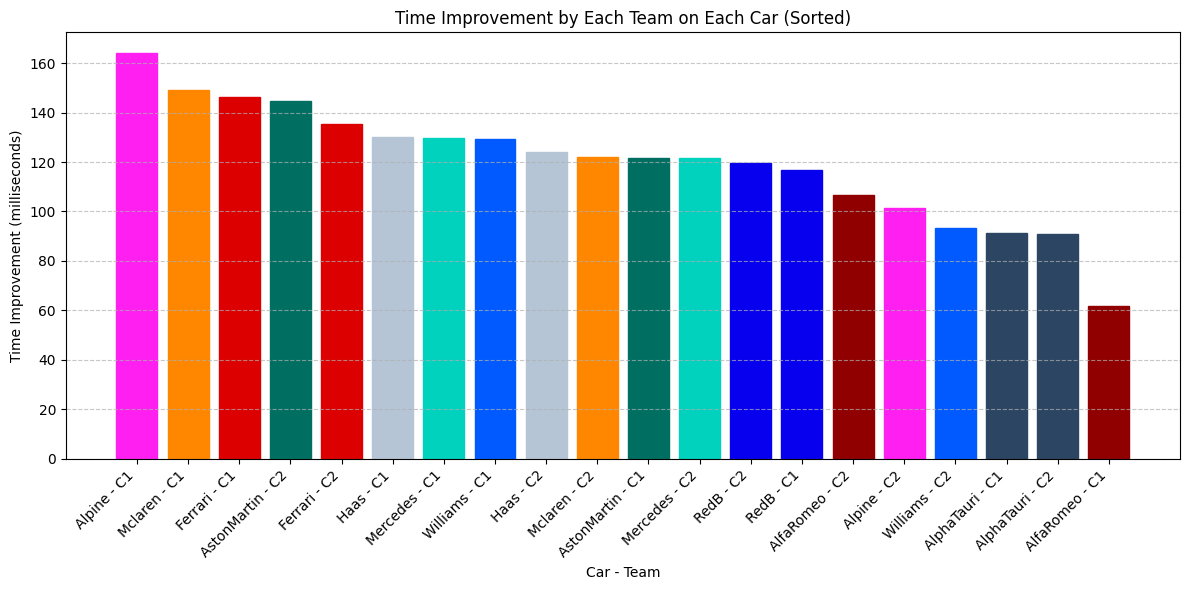

In [117]:
# Assuming you have already executed the code to get total_sum_for_car

# Extract the values (total money spent for each car)
car_values = list(total_time_for_car.values())

# Sort the data by total money invested in descending order
sorted_car_data = sorted(zip(total_sum_for_car.keys(), car_values), key=lambda x: x[1], reverse=True)
sorted_car_keys, sorted_car_values = zip(*sorted_car_data)

# Create a sorted bar plot
plt.figure(figsize=(12, 6))
sorted_car_bars = plt.bar([f"{k[0]} - {k[1]}" for k in sorted_car_keys], sorted_car_values)
for k in sorted_car_keys:
    team = k[0]
    sorted_car_bars[[f"{k[0]} - {k[1]}" for k in sorted_car_keys].index(f"{k[0]} - {k[1]}")].set_color(team_colors[team])

plt.xlabel("Car - Team")
plt.ylabel("Time Improvement (milliseconds)")
plt.title("Time Improvement by Each Team on Each Car (Sorted)")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Display the sorted plot
plt.tight_layout()
plt.show()



Same plot as before but sorted by individual cars instead of grouping it by teams. The Car 1 of Alpine is the one that the most from all the grid!

In [118]:
print("***** Time Improved on each Car of each Team *****")

total_time_improved = 0
for i, total_sum in total_time_for_team.items():
    print(f"Time Improvement in {i} on the Wind Tunnel is: {round(total_sum,3)} milliseconds")
    total_time_improved += total_sum
    
print(f"\nTotal Time Improvement is: {round(model_bin.obj(),3)} that matches {total_time_improved} miliseconds")

***** Time Improved on each Car of each Team *****
Time Improvement in Haas on the Wind Tunnel is: 254.23 milliseconds
Time Improvement in AlphaTauri on the Wind Tunnel is: 182.21 milliseconds
Time Improvement in AlfaRomeo on the Wind Tunnel is: 168.23 milliseconds
Time Improvement in Mclaren on the Wind Tunnel is: 271.13 milliseconds
Time Improvement in Williams on the Wind Tunnel is: 222.85 milliseconds
Time Improvement in AstonMartin on the Wind Tunnel is: 266.45 milliseconds
Time Improvement in Mercedes on the Wind Tunnel is: 251.2 milliseconds
Time Improvement in Alpine on the Wind Tunnel is: 265.48 milliseconds
Time Improvement in Ferrari on the Wind Tunnel is: 282.03 milliseconds
Time Improvement in RedB on the Wind Tunnel is: 236.43 milliseconds

Total Time Improvement is: 2400.24 that matches 2400.24 miliseconds


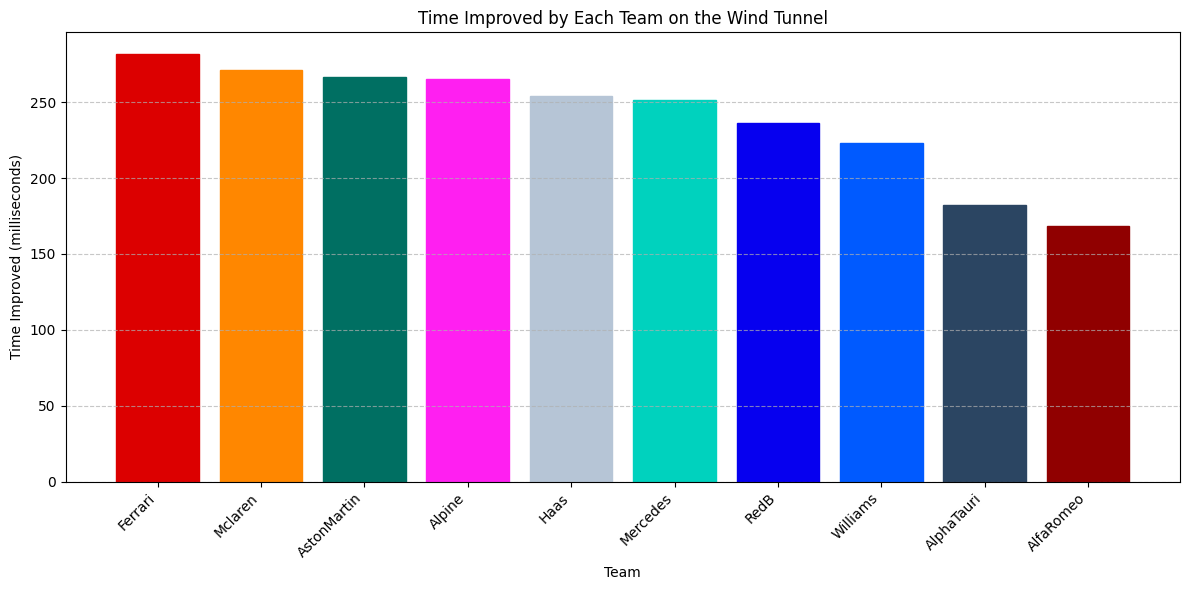

In [119]:
# Sort the data by total money invested for each team in descending order
team_values = list(total_time_for_team.values()); 

sorted_team_data = sorted(zip(total_sum_for_team.keys(), team_values), key=lambda x: x[1], reverse=True)
sorted_team_keys, sorted_team_values = zip(*sorted_team_data)

# Create a sorted bar plot
plt.figure(figsize=(12, 6))
sorted_team_bars = plt.bar(sorted_team_keys, sorted_team_values)
for k in sorted_team_keys:
    sorted_team_bars[sorted_team_keys.index(k)].set_color(team_colors[k])

plt.xlabel('Team')
plt.ylabel('Time Improved (milliseconds)')
plt.title('Time Improved by Each Team on the Wind Tunnel')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Display the sorted plot
plt.tight_layout()
plt.show()


We see that the team that improves the most time is Ferrari, as they were provided better possibilities. They improve 270ms, while Alfa Romeo only improves 160ms. 
On the budget, the team that spent more money was MClaren, and the second was Ferrari, so we can see that Ferrari is performing quite better than MClaren. Alfa Romeo is not doing bad at all, we are going to see it now better: 

# Part 2 Conclusion: 

The Time improvement corresponds to the money allocated to each team, but in order to see something, we are going to obtain the number of milliseconds we obtain per 1000 dollars invested. 
This is going to tell us how efficient is each team investing its money: 

{'Haas': 217465.64, 'AlphaTauri': 139512.81, 'AlfaRomeo': 125561.98999999999, 'Mclaren': 255811.66, 'Williams': 170891.8, 'AstonMartin': 202802.02, 'Mercedes': 203837.16, 'Alpine': 211878.08000000002, 'Ferrari': 225277.27000000002, 'RedB': 139817.3}
{'Haas': 254.23, 'AlphaTauri': 182.20999999999998, 'AlfaRomeo': 168.23000000000002, 'Mclaren': 271.13000000000005, 'Williams': 222.85, 'AstonMartin': 266.45000000000005, 'Mercedes': 251.20000000000002, 'Alpine': 265.47999999999996, 'Ferrari': 282.03, 'RedB': 236.43}
{'Haas': 1.169058247546601, 'AlphaTauri': 1.306044943113109, 'AlfaRomeo': 1.339816293131385, 'Mclaren': 1.059881320499621, 'Williams': 1.3040415046245637, 'AstonMartin': 1.3138429291779248, 'Mercedes': 1.2323562592806927, 'Alpine': 1.252984735372342, 'Ferrari': 1.251923906925896, 'RedB': 1.6909924594452905}


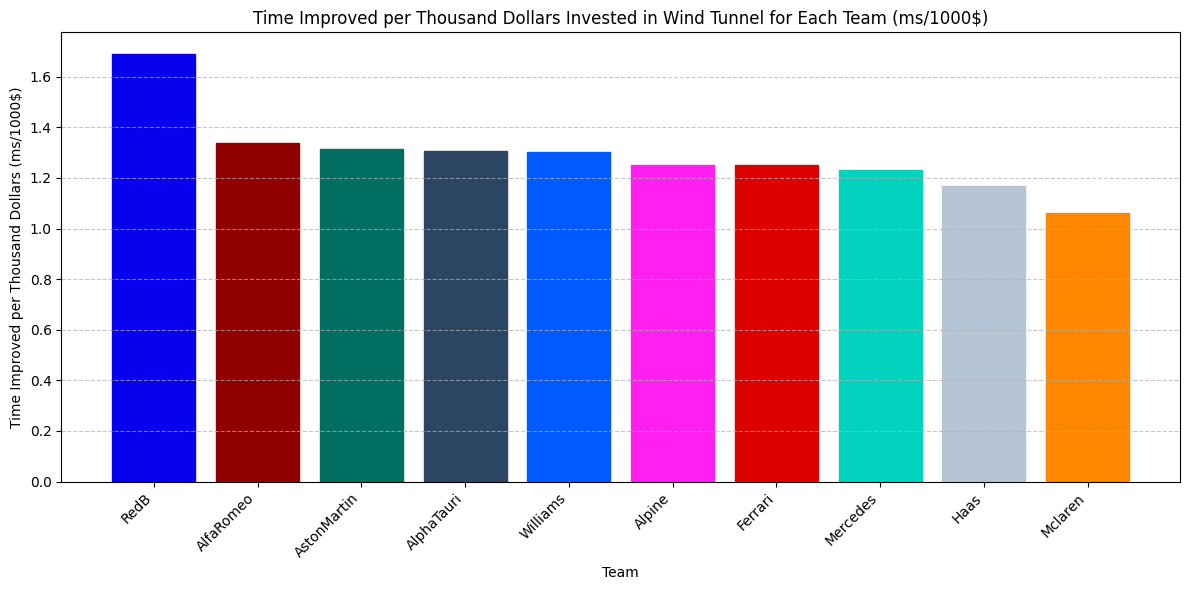

In [120]:
# Calculate time per dollar for each team
time_per_dollar = {team: 1000 * total_time_for_team[team] /  total_sum_for_team[team] for team in Teams }


print(total_sum_for_team) # money
print(total_time_for_team) # time

print(time_per_dollar)

# Sort the data by time per dollar in descending order
sorted_time_per_dollar = sorted(time_per_dollar.items(), key=lambda x: x[1], reverse=True)
sorted_team_keys, sorted_time_per_dollar_values = zip(*sorted_time_per_dollar)

# Create a sorted bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_team_keys, sorted_time_per_dollar_values)
for k in sorted_team_keys:
    bars[sorted_team_keys.index(k)].set_color(team_colors[k])

plt.xlabel('Team')
plt.ylabel('Time Improved per Thousand Dollars (ms/1000$)')
plt.title('Time Improved per Thousand Dollars Invested in Wind Tunnel for Each Team (ms/1000$)')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid
plt.xticks(rotation=45, ha="right")

# Display the sorted plot
plt.tight_layout()
plt.show()


We were saying that Ferrari was doing better than MClaren. This last is the one that invests more money but is the one performing the worst, as per 1000$ invested, they only get 1.05 ms of improvement. While Red Bull, is getting more than 1.7 ms. 
We must notice also that Red Bull outlies in this data due to the fact that most of the teams are quite leveled in the 1.3 ms and Mclaren also outlies but in a bad manner.  

# Conclusion

Through this project we have been able to solve 2 separate problems. 

- First one in which the requirement was to find the best way for the FIA to spend the annual budget on to the different components that each Team could tune in the Wind Tunnel. 
We add a couple of constraints related to the budget of the Team, Car and Componets and finally we have seen which is the Team that performs the best and which is the component that also does.

- Second one was a binary problem, non-linear, where we have the possibility of invest the annual budget of 2023, 2024 and 2025 in different parts of the car. The constraint was that the components had to be tunned for the 3 years consecutively. So when you decide to choose a component is because the final reward time is good enough. Our variable has been binary, whether to tune a component or not, and we have seen a larger differences between the money allocated and the reward obtained, due to the fact that we are now considering 3 period years. 

I have enjoyed quite a lot developing this project, I could say that I am quite happy and proud with the results that we got here. I had lot of difficulties obtaining the Binary representation of the problem as the way to create the problem was different. The most difficult part is the one of thinking how the project is, the main idea, and then the development is easier. 

To finish, just say that this is an approximation of a real problem that the Teams in Formula 1 have to solve in order to invest their money in the Wind Tunnel, since for a few years now, they have limited time for upgrading their cars, a measure introduced the FIA to make the sport more competitive. We have proven it in fact, as the teams with a higher budget are the ones that at the end have the possibility to improve more, but obviously the skill sets are required to achieve it. 